# 1. Importing Packages

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter


# 2. Loading Data

In [10]:
project_data = pd.read_csv('D:\\train_data.csv',nrows = 50000)
resource_data = pd.read_csv('D:\\resources.csv')

In [11]:
print("Number of data points in train data", project_data.shape)
print('='*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (50000, 17)
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [12]:
print("Number of data points in resources data", resource_data.shape)
print(resource_data.columns.values)

Number of data points in resources data (1541272, 4)
['id' 'description' 'quantity' 'price']


In [13]:
resource_data.head()

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   
3  p069063  Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...         2   
4  p069063  EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...         3   

    price  
0  149.00  
1   14.95  
2    8.45  
3   13.59  
4   24.95

In [14]:
project_data.head()

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3          45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4      172407  p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   
3           KY        2016-10-06 21:16:17          Grades PreK-2   
4           TX        2016-07-11 01:10:09          Grades PreK-2   

            project_subject_categories     project_subject_subcategories  \
0                  Literacy & Language                     ESL, Literacy   
1    History & Civics, Health & Sports  Civics & Government, Team Sports   
2                      Health & Sports    Health & Wellness, Team Sports   
3  Literacy & Language, Math & Science             Literacy, Mathematics   
4                       Math & Science                       Mathematics   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   
3                             Techie Kindergarteners   
4                             Interactive Math Tools   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   
3  My students live in high poverty conditions wi...             NaN   
4  For many students, math is a subject that does...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   
3             NaN  My students need to engage in Reading and Math...   
4             NaN  My students need hands on practice in mathemat...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1  
2                                             1                    0  
3                                             4                    1  
4                                             1                    1

In [15]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [16]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [17]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].replace(np.NaN,'Mrs.')

# 3. Text Preprocessing

# 3.1. Concatenating all essay text

In [18]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

# 3.2. Preprocessing Essay text

In [19]:
# printing some random essays.
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)
print(project_data['essay'].values[49999])
print("="*50)


My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

In [20]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent = decontracted(project_data['essay'].values[16499])
print(sent)
print("="*50) 

I teach an amazing, energetic, engaged, and kind group of 5th grade students in an inner city high poverty public school in Indianapolis. Many of my students have parents who work odd hours and have limited time to spend with their wonderfully talented children. My students work hard in class giving 110% with everything that they do. They persevere through difficult topics, enjoy being engaged in their hands-on activities, and they love to laugh while learning. I set high expectation for my students. They understand that true, authentic learning takes hard work, dedication, and requires them to take ownership over their education. My goal for my students is to leave my class as life long learners. The students work hard to overcome all obstacles in their path to meet and grow past my expectations.My students love being active while they are learning and wiggling while they are working. I am lucky enough to have one Hokki stools in my classroom. Sadly, one is not enough to reach all my 

In [22]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

I teach an amazing, energetic, engaged, and kind group of 5th grade students in an inner city high poverty public school in Indianapolis. Many of my students have parents who work odd hours and have limited time to spend with their wonderfully talented children. My students work hard in class giving 110% with everything that they do. They persevere through difficult topics, enjoy being engaged in their hands-on activities, and they love to laugh while learning. I set high expectation for my students. They understand that true, authentic learning takes hard work, dedication, and requires them to take ownership over their education. My goal for my students is to leave my class as life long learners. The students work hard to overcome all obstacles in their path to meet and grow past my expectations.My students love being active while they are learning and wiggling while they are working. I am lucky enough to have one Hokki stools in my classroom. Sadly, one is not enough to reach all my 

In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

I teach an amazing energetic engaged and kind group of 5th grade students in an inner city high poverty public school in Indianapolis Many of my students have parents who work odd hours and have limited time to spend with their wonderfully talented children My students work hard in class giving 110 with everything that they do They persevere through difficult topics enjoy being engaged in their hands on activities and they love to laugh while learning I set high expectation for my students They understand that true authentic learning takes hard work dedication and requires them to take ownership over their education My goal for my students is to leave my class as life long learners The students work hard to overcome all obstacles in their path to meet and grow past my expectations My students love being active while they are learning and wiggling while they are working I am lucky enough to have one Hokki stools in my classroom Sadly one is not enough to reach all my students My student

In [24]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [25]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = sent.lower()
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.strip())

100%|██████████| 50000/50000 [00:27<00:00, 1805.72it/s]


In [26]:
# after preprocesing
preprocessed_essays[20000]

'kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism eager beavers always strive work hardest working past limitations materials ones seek students teach title school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore ever felt like ants pants needed groove move meeting kids feel time want able move learn say wobble chairs answer love develop core enhances gross motor turn fine motor skills also want learn games kids not want sit worksheets want learn count jumping playing physical engagement key success number toss color shape mats make happen students forget work fun 6 year old deserves nannan'

In [27]:
project_data['preprocessed_essays'] = preprocessed_essays 
project_data.drop(['essay'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity                                preprocessed_essays  
0        23  students english learners working english seco...  
1         1  students arrive school eager learn polite gene...

# 3.3. Preprocessing Title text

In [28]:
# printing some random titles.
print(project_data['project_title'].values[0])
print("="*50)
print(project_data['project_title'].values[150])
print("="*50)
print(project_data['project_title'].values[1000])
print("="*50)
print(project_data['project_title'].values[20000])
print("="*50)
print(project_data['project_title'].values[49999])
print("="*50)

Educational Support for English Learners at Home
More Movement with Hokki Stools
Sailing Into a Super 4th Grade Year
We Need To Move It While We Input It!
Inspiring Young Authors Through Reading


In [29]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [30]:
title = decontracted(project_data['project_title'].values[20000])
print(title)
print("="*50)

We Need To Move It While We Input It!


In [31]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
title = title.replace('\\r', ' ')
title = title.replace('\\"', ' ')
title = title.replace('\\n', ' ')
print(title)

We Need To Move It While We Input It!


In [32]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
title = re.sub('[^A-Za-z0-9]+', ' ', title)
print(title)

We Need To Move It While We Input It 


In [33]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [34]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for t in tqdm(project_data['project_title'].values):
    title = decontracted(t)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    # https://gist.github.com/sebleier/554280
    title = title.lower()
    title = ' '.join(e for e in title.split() if e not in stopwords)
    preprocessed_titles.append(title.strip())

100%|██████████| 50000/50000 [00:01<00:00, 40377.60it/s]


In [35]:
# after preprocesing
preprocessed_titles[20000]

'need move input'

In [36]:
project_data['preprocessed_titles'] = preprocessed_titles
project_data.drop(['project_title'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity                                preprocessed_essays  \
0        23  students english learners working english seco...   
1         1  students arrive school eager learn polite gene...   

                         preprocessed_titles  
0  educational support english learners home  
1           wanted projector hungry learners

In [37]:
project_data.head()

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3          45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4      172407  p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   
3           KY        2016-10-06 21:16:17          Grades PreK-2   
4           TX        2016-07-11 01:10:09          Grades PreK-2   

            project_subject_categories     project_subject_subcategories  \
0                  Literacy & Language                     ESL, Literacy   
1    History & Civics, Health & Sports  Civics & Government, Team Sports   
2                      Health & Sports    Health & Wellness, Team Sports   
3  Literacy & Language, Math & Science             Literacy, Mathematics   
4                       Math & Science                       Mathematics   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   
3  My students live in high poverty conditions wi...             NaN   
4  For many students, math is a subject that does...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   
3             NaN  My students need to engage in Reading and Math...   
4             NaN  My students need hands on practice in mathemat...   

   teacher_number_of_previously_posted_projects  project_is_approved   price  \
0                                             0                    0  154.60   
1                                             7                    1  299.00   
2                                             1                    0  516.85   
3                                             4                    1  232.90   
4                                             1                    1   67.98   

   quantity                                preprocessed_essays  \
0        23  students english learners working english seco...   
1         1  students arrive school eager learn polite gene...   
2        22  true champions not always ones win guts mia ha...   
3         4  work unique school filled esl english second l...   
4         4  second grade classroom next year made around 2...   

                               preprocessed_titles  
0        educational support english learners home  
1                 wanted projector hungry learners  
2  soccer equipment awesome middle school students  
3                           techie kindergarteners  
4                           interactive math tools

# 3.4. Preprocessing project_grade_category

In [38]:
project_grade_clean_category = []

for i in range(len(project_data)):
    a = project_data["project_grade_category"][i].replace(" ", "_").replace("-", "_")
    project_grade_clean_category.append(a)

In [39]:
project_grade_clean_category[0:5]

['Grades_PreK_2', 'Grades_6_8', 'Grades_6_8', 'Grades_PreK_2', 'Grades_PreK_2']

In [40]:
project_data['project_grade_clean_category'] = project_grade_clean_category 
project_data.drop(['project_grade_category'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime         project_subject_categories  \
0           IN        2016-12-05 13:43:57                Literacy & Language   
1           FL        2016-10-25 09:22:10  History & Civics, Health & Sports   

      project_subject_subcategories  \
0                     ESL, Literacy   
1  Civics & Government, Team Sports   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity                                preprocessed_essays  \
0        23  students english learners working english seco...   
1         1  students arrive school eager learn polite gene...   

                         preprocessed_titles project_grade_clean_category  
0  educational support english learners home                Grades_PreK_2  
1           wanted projector hungry learners                   Grades_6_8

# 3.5. Preprocessing project_subject_categories

In [41]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [42]:
cat_list[0:5]

['Literacy_Language',
 'History_Civics Health_Sports',
 'Health_Sports',
 'Literacy_Language Math_Science',
 'Math_Science']

In [43]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime     project_subject_subcategories  \
0           IN        2016-12-05 13:43:57                     ESL, Literacy   
1           FL        2016-10-25 09:22:10  Civics & Government, Team Sports   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity                                preprocessed_essays  \
0        23  students english learners working english seco...   
1         1  students arrive school eager learn polite gene...   

                         preprocessed_titles project_grade_clean_category  \
0  educational support english learners home                Grades_PreK_2   
1           wanted projector hungry learners                   Grades_6_8   

               clean_categories  
0             Literacy_Language  
1  History_Civics Health_Sports

# 3.6. Preprocessing project_subject_subcategories

In [44]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [45]:
sub_cat_list[0:5]

['ESL Literacy',
 'Civics_Government TeamSports',
 'Health_Wellness TeamSports',
 'Literacy Mathematics',
 'Mathematics']

In [46]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(5)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3          45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4      172407  p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   

  school_state project_submitted_datetime  \
0           IN        2016-12-05 13:43:57   
1           FL        2016-10-25 09:22:10   
2           AZ        2016-08-31 12:03:56   
3           KY        2016-10-06 21:16:17   
4           TX        2016-07-11 01:10:09   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   
3  My students live in high poverty conditions wi...             NaN   
4  For many students, math is a subject that does...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   
3             NaN  My students need to engage in Reading and Math...   
4             NaN  My students need hands on practice in mathemat...   

   teacher_number_of_previously_posted_projects  project_is_approved   price  \
0                                             0                    0  154.60   
1                                             7                    1  299.00   
2                                             1                    0  516.85   
3                                             4                    1  232.90   
4                                             1                    1   67.98   

   quantity                                preprocessed_essays  \
0        23  students english learners working english seco...   
1         1  students arrive school eager learn polite gene...   
2        22  true champions not always ones win guts mia ha...   
3         4  work unique school filled esl english second l...   
4         4  second grade classroom next year made around 2...   

                               preprocessed_titles  \
0        educational support english learners home   
1                 wanted projector hungry learners   
2  soccer equipment awesome middle school students   
3                           techie kindergarteners   
4                           interactive math tools   

  project_grade_clean_category                clean_categories  \
0                Grades_PreK_2               Literacy_Language   
1                   Grades_6_8    History_Civics Health_Sports   
2                   Grades_6_8                   Health_Sports   
3                Grades_PreK_2  Literacy_Language Math_Science   
4                Grades_PreK_2                    Math_Science   

            clean_subcategories  
0                  ESL Literacy  
1  Civics_Government TeamSports  
2    Health_Wellness TeamSports  
3          Literacy Mathematics  
4                   Mathematics

# 4. Splitting data into Train and cross validation(or test): Stratified Sampling

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(project_data, project_data['project_is_approved'], test_size=0.33, stratify = project_data['project_is_approved'])
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

# 5. Dropping Target values from Train, Test and CV set

In [48]:
X_train.drop(['project_is_approved'], axis=1, inplace=True)
X_test.drop(['project_is_approved'], axis=1, inplace=True)
X_cv.drop(['project_is_approved'], axis=1, inplace=True)

In [49]:
print(X_train.shape)
print(X_test.shape)
print(X_cv.shape)

(22445, 19)
(16500, 19)
(11055, 19)


In [50]:
X_train.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
5658      167487  p030511  67aef6e22c00ef8a9f0936095414d0c8            Mr.   
7497       54745  p013501  2bcdc75056a431aae98d6fac11f67787           Mrs.   

     school_state project_submitted_datetime  \
5658           MN        2016-11-06 12:59:17   
7497           NY        2016-10-03 09:55:30   

                                        project_essay_1  \
5658  My students are a group of fun, energetic stud...   
7497  My students are smart, motivated, and caring k...   

                                        project_essay_2 project_essay_3  \
5658  Having these portable resource centers will he...             NaN   
7497  My students said the want more standing desks!...             NaN   

     project_essay_4                           project_resource_summary  \
5658             NaN  My students need these pocket charts and stand...   
7497             NaN  My students need 4 standing desks with swingin...   

      teacher_number_of_previously_posted_projects   price  quantity  \
5658                                             2  104.98         4   
7497                                            66  214.69         3   

                                    preprocessed_essays  \
5658  students group fun energetic students excited ...   
7497  students smart motivated caring kids excited c...   

                                    preprocessed_titles  \
5658  students taking responsibility learning portab...   
7497                           keeping bodies moving ii   

     project_grade_clean_category                clean_categories  \
5658                Grades_PreK_2  Literacy_Language Math_Science   
7497                   Grades_6_8      Health_Sports SpecialNeeds   

                 clean_subcategories  
5658  Literature_Writing Mathematics  
7497    Health_Wellness SpecialNeeds

In [51]:
y_train.head(10)

5658     1
7497     1
26305    1
18437    1
7590     1
47476    1
24593    1
24006    1
29840    1
45625    1
Name: project_is_approved, dtype: int64

# Method 1:

# Working of Response Coding

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [134]:
# combine_xy = pd.concat([X_train,y_train],axis = 1)

In [135]:
# combine_xy.head()

Unnamed: 0       id                        teacher_id teacher_prefix  \
10007      128696  p100675  19831e83439fecd7126d90f9bed7ed97           Mrs.   
17077      144988  p228015  d3a250dc853151963992a016f5836e01            Ms.   
28354      173218  p034881  3f440f54c74c9ddfff49864d1787ad00           Mrs.   
11779       22215  p239368  4f6582127ca2840a9d9064bb79119315            Ms.   
27680       80133  p194308  682bcf32e9cba62e6d415c5f4efa13bd           Mrs.   

      school_state project_submitted_datetime  \
10007           FL        2016-08-09 17:44:30   
17077           OR        2017-01-11 02:49:24   
28354           LA        2016-09-22 20:08:06   
11779           CA        2016-09-30 21:20:01   
27680           SC        2016-10-19 22:05:30   

                                         project_essay_1  \
10007  My students are always full of life and ready ...   
17077  As a teacher in a low-income/high poverty scho...   
28354  My students do not have the number of experien...   
11779  My students are taking college preparatory gen...   
27680  I am currently a third grade teacher in a Titl...   

                                         project_essay_2 project_essay_3  \
10007  My students need Teamson Kids - Little Chef Wo...             NaN   
17077  Students learn in a multitude of ways. The stu...             NaN   
28354  Students came to school for six days.  After t...             NaN   
11779  My students will use these calculators through...             NaN   
27680  Many students in schools across the country st...             NaN   

      project_essay_4                           project_resource_summary  \
10007             NaN  My students need a dramatic play area consisti...   
17077             NaN  My students need alternative seating options f...   
28354             NaN  My students need binders, folders with Velcro,...   
11779             NaN  My students need TI-30XIIs scientific calculat...   
27680             NaN  My students need fitness equipment in the clas...   

       teacher_number_of_previously_posted_projects   price  quantity  \
10007                                             6  111.97         3   
17077                                             3  139.71        17   
28354                                            58  141.47        31   
11779                                             0   13.16        30   
27680                                             0   86.10        10   

                                     preprocessed_essays  \
10007  students always full life ready take world lov...   
17077  teacher low income high poverty school large d...   
28354  students not number experiences many children ...   
11779  students taking college preparatory general ho...   
27680  currently third grade teacher title one school...   

                                     preprocessed_titles  \
10007  future master chefs need play kitchen expand i...   
17077                 special seating superstar students   
28354                            flooding takes supplies   
11779                              calculating chemistry   
27680                                   learning steppin   

      project_grade_clean_category                clean_categories  \
10007                Grades_PreK_2    AppliedLearning SpecialNeeds   
17077                Grades_PreK_2  Literacy_Language Math_Science   
28354                Grades_PreK_2                    Math_Science   
11779                  Grades_9_12                    Math_Science   
27680                   Grades_3_5                   Health_Sports   

                  clean_subcategories  project_is_approved  
10007   EarlyDevelopment SpecialNeeds                    1  
17077  Literature_Writing Mathematics                    1  
28354                     Mathematics                    1  
11779                 AppliedSciences                    1  
27680     Gym_Fitness Health_Wellness                    1

In [136]:
# a = combine_xy.groupby(['clean_categories','project_is_approved']).size()

In [137]:
# a = a.unstack()

In [138]:
# a.head()

project_is_approved                    0      1
clean_categories                               
AppliedLearning                    152.0  626.0
AppliedLearning Health_Sports       21.0  105.0
AppliedLearning History_Civics       7.0   21.0
AppliedLearning Literacy_Language   77.0  362.0
AppliedLearning Math_Science        37.0  176.0

In [139]:
# #https://stackoverflow.com/questions/37840043/pandas-unstack-column-values-into-new-columns
# b = a.rename_axis([None],axis = 1).reset_index()

In [140]:
# b.head()

clean_categories      0      1
0                    AppliedLearning  152.0  626.0
1      AppliedLearning Health_Sports   21.0  105.0
2     AppliedLearning History_Civics    7.0   21.0
3  AppliedLearning Literacy_Language   77.0  362.0
4       AppliedLearning Math_Science   37.0  176.0

In [141]:
# c = b.rename({0: "project_not_approved",1:"project_approved"},axis = 1) 

In [142]:
# c.head()

clean_categories  project_not_approved  project_approved
0                    AppliedLearning                 152.0             626.0
1      AppliedLearning Health_Sports                  21.0             105.0
2     AppliedLearning History_Civics                   7.0              21.0
3  AppliedLearning Literacy_Language                  77.0             362.0
4       AppliedLearning Math_Science                  37.0             176.0

In [143]:
# c['sum'] = c['project_not_approved'] + c['project_approved']

In [144]:
# c.head()

clean_categories  project_not_approved  project_approved  \
0                    AppliedLearning                 152.0             626.0   
1      AppliedLearning Health_Sports                  21.0             105.0   
2     AppliedLearning History_Civics                   7.0              21.0   
3  AppliedLearning Literacy_Language                  77.0             362.0   
4       AppliedLearning Math_Science                  37.0             176.0   

     sum  
0  778.0  
1  126.0  
2   28.0  
3  439.0  
4  213.0

In [145]:
# c['clean_category_not_accepted'] = c['project_not_approved'] / c['sum']

In [146]:
# c['clean_category_accepted'] = c['project_approved'] / c['sum']

In [147]:
# c.head()

clean_categories  project_not_approved  project_approved  \
0                    AppliedLearning                 152.0             626.0   
1      AppliedLearning Health_Sports                  21.0             105.0   
2     AppliedLearning History_Civics                   7.0              21.0   
3  AppliedLearning Literacy_Language                  77.0             362.0   
4       AppliedLearning Math_Science                  37.0             176.0   

     sum  clean_category_not_accepted  clean_category_accepted  
0  778.0                     0.195373                 0.804627  
1  126.0                     0.166667                 0.833333  
2   28.0                     0.250000                 0.750000  
3  439.0                     0.175399                 0.824601  
4  213.0                     0.173709                 0.826291

In [148]:
# d = c[['clean_categories','clean_category_not_accepted','clean_category_accepted']]

In [149]:
# d.head()

clean_categories  clean_category_not_accepted  \
0                    AppliedLearning                     0.195373   
1      AppliedLearning Health_Sports                     0.166667   
2     AppliedLearning History_Civics                     0.250000   
3  AppliedLearning Literacy_Language                     0.175399   
4       AppliedLearning Math_Science                     0.173709   

   clean_category_accepted  
0                 0.804627  
1                 0.833333  
2                 0.750000  
3                 0.824601  
4                 0.826291

In [150]:
# d.shape

(49, 3)

In [151]:
# # mergedStuff = pd.merge(df1, df2, on=['Name'], how='inner')
# # mergedStuff.head()
# X_train = pd.merge(X_train, d, on=['clean_categories'], how='inner')

In [152]:
# X_train.head()

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      128696  p100675  19831e83439fecd7126d90f9bed7ed97           Mrs.   
1       16876  p169319  04cb0557218fc7edbbc32f3164be1eee            Mr.   
2      103755  p174526  c4a8db6cc37978558c142e0d29993b1e            Ms.   
3      131557  p234179  d60659e1f1da84bdca1e8971bb1bcb2b           Mrs.   
4       59284  p076757  bbc1ed8de159d60eefd6b48b7522cd36            Ms.   

  school_state project_submitted_datetime  \
0           FL        2016-08-09 17:44:30   
1           LA        2016-07-27 22:28:45   
2           CT        2016-10-06 15:06:01   
3           KS        2016-08-04 19:41:51   
4           MA        2017-03-07 12:47:35   

                                     project_essay_1  \
0  My students are always full of life and ready ...   
1  All kids deserve to be praised and rewarded fo...   
2  Each day my students walk into our building fa...   
3  My students like all Kindergarten students are...   
4  I currently have a classroom of six little sma...   

                                     project_essay_2 project_essay_3  \
0  My students need Teamson Kids - Little Chef Wo...             NaN   
1  My students continue to defy the statistics an...             NaN   
2  My students and their families are sometimes u...             NaN   
3  I'd like to provide a variety of seating optio...             NaN   
4  These 3 dividers are going to be the best addi...             NaN   

  project_essay_4  ... teacher_number_of_previously_posted_projects   price  \
0             NaN  ...                                            6  111.97   
1             NaN  ...                                            4  343.33   
2             NaN  ...                                            2  164.95   
3             NaN  ...                                            0  261.37   
4             NaN  ...                                            2  387.00   

   quantity                                preprocessed_essays  \
0         3  students always full life ready take world lov...   
1        25  kids deserve praised rewarded things right tod...   
2        12  day students walk building facing multitude ch...   
3        12  students like kindergarten students fun energe...   
4         3  currently classroom six little smarties classr...   

                                 preprocessed_titles  \
0  future master chefs need play kitchen expand i...   
1                              kids deserve rewarded   
2                                      diamond rough   
3                                         let wiggle   
4         look gaining attention focusing learners n   

  project_grade_clean_category              clean_categories  \
0                Grades_PreK_2  AppliedLearning SpecialNeeds   
1                   Grades_3_5  AppliedLearning SpecialNeeds   
2                   Grades_6_8  AppliedLearning SpecialNeeds   
3                Grades_PreK_2  AppliedLearning SpecialNeeds   
4                Grades_PreK_2  AppliedLearning SpecialNeeds   

               clean_subcategories clean_category_not_accepted  \
0    EarlyDevelopment SpecialNeeds                     0.18038   
1  CharacterEducation SpecialNeeds                     0.18038   
2    CommunityService SpecialNeeds                     0.18038   
3    EarlyDevelopment SpecialNeeds                     0.18038   
4    EarlyDevelopment SpecialNeeds                     0.18038   

   clean_category_accepted  
0                  0.81962  
1                  0.81962  
2                  0.81962  
3                  0.81962  
4                  0.81962  

[5 rows x 21 columns]

In [163]:
# X_train.isnull().any()

Unnamed: 0                                      False
id                                              False
teacher_id                                      False
teacher_prefix                                  False
school_state                                    False
project_submitted_datetime                      False
project_essay_1                                 False
project_essay_2                                 False
project_essay_3                                  True
project_essay_4                                  True
project_resource_summary                        False
teacher_number_of_previously_posted_projects    False
price                                           False
quantity                                        False
preprocessed_essays                             False
preprocessed_titles                             False
project_grade_clean_category                    False
clean_categories                                False
clean_subcategories         

In [164]:
# X_train["clean_category_not_accepted"].fillna(0.5, inplace = True) 

In [165]:
# X_train["clean_category_accepted"].fillna(0.5, inplace = True) 

In [166]:
# X_train.isnull().any()

Unnamed: 0                                      False
id                                              False
teacher_id                                      False
teacher_prefix                                  False
school_state                                    False
project_submitted_datetime                      False
project_essay_1                                 False
project_essay_2                                 False
project_essay_3                                  True
project_essay_4                                  True
project_resource_summary                        False
teacher_number_of_previously_posted_projects    False
price                                           False
quantity                                        False
preprocessed_essays                             False
preprocessed_titles                             False
project_grade_clean_category                    False
clean_categories                                False
clean_subcategories         

In [167]:
# categories_response_code_Xtrain = X_train[['clean_category_not_accepted','clean_category_accepted']].values

In [168]:
# categories_response_code_Xtrain

array([[0.18037975, 0.81962025],
       [0.18037975, 0.81962025],
       [0.18037975, 0.81962025],
       ...,
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ]])

In [173]:
# from scipy import sparse
# categories_response_code_Xtrain = sparse.csr_matrix(categories_response_code_Xtrain)

In [174]:
# categories_response_code_Xtrain

<22445x2 sparse matrix of type '<class 'numpy.float64'>'
	with 44890 stored elements in Compressed Sparse Row format>

In [169]:
# categories_response_code_Xtrain.shape

(22445, 2)

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Method 2

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [44]:
# #Concatenating X_train and Y_train 
# combine_xy = pd.concat([X_train,y_train],axis = 1)

# #grouping categories on project_is_approved,unstacking and renaming the unstacked data
# #https://stackoverflow.com/questions/37840043/pandas-unstack-column-values-into-new-columns
# a = combine_xy.groupby(['clean_categories','project_is_approved']).size().unstack().rename_axis([None],axis = 1).reset_index()

# b = a.rename({0: "project_not_approved",1:"project_approved"},axis = 1) 

# # computations for finding probabilities for each classes
# b['sum'] = b['project_not_approved'] + b['project_approved']
# b['clean_categories_not_accepted'] = b['project_not_approved'] / b['sum']
# b['clean_categories_accepted'] = b['project_approved'] / b['sum']

# # probabilities computed for X_train
# probabilities_Xtrain_clean_categories = b[['clean_categories','clean_categories_not_accepted','clean_categories_accepted']]

In [340]:
# probabilities_Xtrain_clean_categories.head()

clean_categories  clean_categories_not_accepted  \
0                    AppliedLearning                       0.180412   
1      AppliedLearning Health_Sports                       0.150000   
2     AppliedLearning History_Civics                       0.166667   
3  AppliedLearning Literacy_Language                       0.129670   
4       AppliedLearning Math_Science                       0.194175   

   clean_categories_accepted  
0                   0.819588  
1                   0.850000  
2                   0.833333  
3                   0.870330  
4                   0.805825

In [341]:
# x = probabilities_Xtrain_clean_categories.set_index('clean_categories').T.to_dict('list')

In [342]:
# print(x)

{'AppliedLearning': [0.18041237113402062, 0.8195876288659794], 'AppliedLearning Health_Sports': [0.15, 0.85], 'AppliedLearning History_Civics': [0.16666666666666666, 0.8333333333333334], 'AppliedLearning Literacy_Language': [0.12967032967032968, 0.8703296703296703], 'AppliedLearning Math_Science': [0.1941747572815534, 0.8058252427184466], 'AppliedLearning Music_Arts': [0.21739130434782608, 0.782608695652174], 'AppliedLearning SpecialNeeds': [0.1779935275080906, 0.8220064724919094], 'AppliedLearning Warmth Care_Hunger': [nan, nan], 'Health_Sports': [0.15208034433285508, 0.8479196556671449], 'Health_Sports AppliedLearning': [0.25, 0.75], 'Health_Sports History_Civics': [nan, nan], 'Health_Sports Literacy_Language': [0.1736842105263158, 0.8263157894736842], 'Health_Sports Math_Science': [0.2727272727272727, 0.7272727272727273], 'Health_Sports Music_Arts': [0.25925925925925924, 0.7407407407407407], 'Health_Sports SpecialNeeds': [0.13553113553113552, 0.8644688644688645], 'Health_Sports Warm

In [343]:
# type(x)

dict

In [344]:
# cat = []

In [345]:
# for i in X_train['clean_categories']:
#     if(i in x):
#         cat.append(x[i])

In [346]:
# cat[0:5]

[[0.19469026548672566, 0.8053097345132744],
 [0.15208034433285508, 0.8479196556671449],
 [0.14083350441387804, 0.8591664955861219],
 [0.12394957983193278, 0.8760504201680672],
 [0.14083350441387804, 0.8591664955861219]]

In [347]:
# df = pd.DataFrame.from_records(cat, columns=["clean_categories_not_approved", "clean_categories_approved"])

In [348]:
# df.head()

clean_categories_not_approved  clean_categories_approved
0                       0.194690                   0.805310
1                       0.152080                   0.847920
2                       0.140834                   0.859166
3                       0.123950                   0.876050
4                       0.140834                   0.859166

In [349]:
# X_train.head()

Unnamed: 0       id                        teacher_id teacher_prefix  \
22394       96904  p178231  37c8e089e72aac2a226dfb6aa230d662            Mr.   
31806      119026  p035768  7c605c5654515b38b026c0c30da2dde4           Mrs.   
9582       165293  p229215  55e6824491cd70ec6a434022154df85f            Ms.   
36957      133415  p173112  470cdf6aac6bb1a40e6b50a21040c714           Mrs.   
30435       89343  p136023  f52f7b8b44f5e64dee41e04006611d01            Ms.   

      school_state project_submitted_datetime  \
22394           OH        2017-04-13 10:19:57   
31806           SC        2016-08-03 19:48:39   
9582            IN        2016-06-26 13:43:45   
36957           TX        2016-06-29 21:23:45   
30435           CA        2016-12-29 00:59:37   

                                         project_essay_1  \
22394  The Dawson-Bryant Local School District is loc...   
31806  A majority of my students come from a lower in...   
9582   We are fisherman set out to fill our nets with...   
36957  As you enter my classroom, be prepared for a b...   
30435  My students are excited to learn every day whe...   

                                         project_essay_2 project_essay_3  \
22394  My students, with the wood planer, would have ...             NaN   
31806  My students are very active kids and LOVE to p...             NaN   
9582   Several students will not travel far beyond ou...             NaN   
36957  Why?  How?  Those are questions that I am aske...             NaN   
30435  There is such power in reading.  We make frien...             NaN   

      project_essay_4                           project_resource_summary  \
22394             NaN  My students need this DeWalt planer to dimensi...   
31806             NaN  My students need classroom exercise equipment,...   
9582              NaN  My students need these engaging mentor texts t...   
36957             NaN  My students need laptops in order to incorpora...   
30435             NaN  My students need a classroom set of books that...   

       teacher_number_of_previously_posted_projects   price  quantity  \
22394                                             0  549.99         1   
31806                                            14  660.63        14   
9582                                              0  440.25        50   
36957                                             0  419.99         2   
30435                                             3   17.06        35   

                                     preprocessed_essays  \
22394  dawson bryant local school district located be...   
31806  majority students come lower income background...   
9582   fisherman set fill nets knowledge come various...   
36957  enter classroom prepared bear sized hug wholeh...   
30435  students excited learn every day enter classro...   

                               preprocessed_titles  \
22394              full steam ahead guitar edition   
31806                bringing gym classroom beyond   
9582   books exploring new adventures various ways   
36957                            star techies r us   
30435      help students discover power great book   

      project_grade_clean_category                clean_categories  \
22394                   Grades_6_8         Math_Science Music_Arts   
31806                Grades_PreK_2                   Health_Sports   
9582                    Grades_3_5               Literacy_Language   
36957                Grades_PreK_2  Math_Science Literacy_Language   
30435                   Grades_3_5               Literacy_Language   

                 clean_subcategories  
22394          AppliedSciences Music  
31806    Gym_Fitness Health_Wellness  
9582              Literature_Writing  
36957  EnvironmentalScience Literacy  
30435             Literature_Writing

In [350]:
# df.shape

(22445, 2)

In [351]:
# df.isnull().any()

clean_categories_not_approved    True
clean_categories_approved        True
dtype: bool

In [352]:
# df['column'] = df['column'].replace(np.nan, 0)


In [353]:
# df.fillna(0.5 ,inplace = True)

In [355]:
# df.head()

clean_categories_not_approved  clean_categories_approved
0                       0.194690                   0.805310
1                       0.152080                   0.847920
2                       0.140834                   0.859166
3                       0.123950                   0.876050
4                       0.140834                   0.859166

In [356]:
# df.isnull().any()

clean_categories_not_approved    False
clean_categories_approved        False
dtype: bool

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# 6. Encoding Categorical Data

# 6.1. Response coding of clean_categories

In [52]:
#Concatenating X_train and Y_train 
combine_xy = pd.concat([X_train,y_train],axis = 1)

#grouping categories on project_is_approved,unstacking and renaming the unstacked data
#https://stackoverflow.com/questions/37840043/pandas-unstack-column-values-into-new-columns
a = combine_xy.groupby(['clean_categories','project_is_approved']).size().unstack().rename_axis([None],axis = 1).reset_index()

b = a.rename({0: "project_not_approved",1:"project_approved"},axis = 1) 

# computations for finding probabilities for each classes
b['sum'] = b['project_not_approved'] + b['project_approved']
b['clean_categories_not_accepted'] = b['project_not_approved'] / b['sum']
b['clean_categories_accepted'] = b['project_approved'] / b['sum']

# probabilities computed for X_train
probabilities_Xtrain_clean_categories = b[['clean_categories','clean_categories_not_accepted','clean_categories_accepted']]


In [53]:
clean_categories_to_dict = probabilities_Xtrain_clean_categories.set_index('clean_categories').T.to_dict('list')

In [54]:
cat_train = []
for i in X_train['clean_categories']:
    if(i in clean_categories_to_dict):
        cat_train.append(clean_categories_to_dict[i])
    else:
        cat_train.append([0.5,0.5])
    
        
categories_response_code_Xtrain = pd.DataFrame.from_records(cat_train, columns=["clean_categories_not_approved", "clean_categories_approved"])

# replacing null values
categories_response_code_Xtrain.fillna(0.5,inplace = True)

In [55]:
# response coding for X_train
from scipy import sparse

categories_response_code_Xtrain = sparse.csr_matrix(categories_response_code_Xtrain)
print(categories_response_code_Xtrain.shape)

(22445, 2)


In [56]:
cat_test = []
for i in X_test['clean_categories']:
    if(i in clean_categories_to_dict):
        cat_test.append(clean_categories_to_dict[i])
    else:
        cat_test.append([0.5,0.5])
        
categories_response_code_Xtest = pd.DataFrame.from_records(cat_test, columns=["clean_categories_not_approved", "clean_categories_approved"])

# replacing null values
categories_response_code_Xtest.fillna(0.5,inplace = True)

In [57]:
categories_response_code_Xtest.shape

(16500, 2)

In [117]:
# cat_test = []
# val = X_test['clean_categories']
# count = 0
# for x in  X_test['clean_categories']:
#     count = count + 1
# print(count)
# #     # to do 
# #     if(val in clean_categories_to_dict):
# #         cat_test.append(clean_categories_to_dict[val])
        
# # categories_response_code_Xtest = pd.DataFrame.from_records(cat_test, columns=["clean_categories_not_approved", "clean_categories_approved"])

# # # replacing null values
# # categories_response_code_Xtest.fillna(0.5,inplace = True)
    
    

16500


In [193]:
DF_new_row=categories_response_code_Xtest.loc[categories_response_code_Xtest['clean_categories_not_approved']=='']


In [194]:
DF_new_row

Empty DataFrame
Columns: [clean_categories_not_approved, clean_categories_approved]
Index: []

In [195]:
# categories_response_code_Xtest[categories_response_code_Xtest['clean_categories_not_approved'] == ''].index

Int64Index([], dtype='int64')

In [196]:
# categories_response_code_Xtest[categories_response_code_Xtest['clean_categories_not_approved'].isnull()].index

Int64Index([], dtype='int64')

In [212]:
# is_0_5 =  categories_response_code_Xtest['clean_categories_not_approved'] == 0.5
# gapminder_0_5 =categories_response_code_Xtest[is_0_5]

In [215]:
# gapminder_0_5.shape

(22, 2)

In [199]:
# categories_response_code_Xtest.shape

(16500, 2)

In [58]:
# response coding for X_test
from scipy import sparse

categories_response_code_Xtest = sparse.csr_matrix(categories_response_code_Xtest)
print(categories_response_code_Xtest.shape)

(16500, 2)


In [59]:
cat_cv = []
for i in X_cv['clean_categories']:
    if(i in clean_categories_to_dict):
        cat_cv.append(clean_categories_to_dict[i])
    else:
        cat_cv.append([0.5,0.5])
        
categories_response_code_Xcv = pd.DataFrame.from_records(cat_cv, columns=["clean_categories_not_approved", "clean_categories_approved"])

# replacing null values
categories_response_code_Xcv.fillna(0.5,inplace = True)

In [60]:
# response coding for X_cv
from scipy import sparse

categories_response_code_Xcv = sparse.csr_matrix(categories_response_code_Xcv)
print(categories_response_code_Xcv.shape)

(11055, 2)


# 6.2. Response coding of clean_subcategories

In [61]:
#Concatenating X_train and Y_train 
combine_xy = pd.concat([X_train,y_train],axis = 1)

#grouping categories on project_is_approved,unstacking and renaming the unstacked data
#https://stackoverflow.com/questions/37840043/pandas-unstack-column-values-into-new-columns
a = combine_xy.groupby(['clean_subcategories','project_is_approved']).size().unstack().rename_axis([None],axis = 1).reset_index()

b = a.rename({0: "project_not_approved",1:"project_approved"},axis = 1) 

# computations for finding probabilities for each classes
b['sum'] = b['project_not_approved'] + b['project_approved']
b['clean_subcategories_not_accepted'] = b['project_not_approved'] / b['sum']
b['clean_subcategories_accepted'] = b['project_approved'] / b['sum']

# probabilities computed for X_train
probabilities_Xtrain_clean_subcategories = b[['clean_subcategories','clean_subcategories_not_accepted','clean_subcategories_accepted']]


In [62]:
clean_subcategories_to_dict = probabilities_Xtrain_clean_subcategories.set_index('clean_subcategories').T.to_dict('list')

In [63]:
cat_train = []
for i in X_train['clean_subcategories']:
    if(i in clean_subcategories_to_dict):
        cat_train.append(clean_subcategories_to_dict[i])
    else:
        cat_train.append([0.5,0.5])
        
subcategories_response_code_Xtrain = pd.DataFrame.from_records(cat_train, columns=["clean_subcategories_not_approved", "clean_subcategories_approved"])

# replacing null values
subcategories_response_code_Xtrain.fillna(0.5,inplace = True)

In [64]:
# response coding for X_train
from scipy import sparse

subcategories_response_code_Xtrain = sparse.csr_matrix(subcategories_response_code_Xtrain)
print(subcategories_response_code_Xtrain.shape)

(22445, 2)


In [65]:
cat_test = []
for i in X_test['clean_subcategories']:
    if(i in clean_subcategories_to_dict):
        cat_test.append(clean_subcategories_to_dict[i])
    else:
        cat_test.append([0.5,0.5])
        
subcategories_response_code_Xtest = pd.DataFrame.from_records(cat_test, columns=["clean_subcategories_not_approved", "clean_subcategories_approved"])

# replacing null values
subcategories_response_code_Xtest.fillna(0.5,inplace = True)

In [66]:
# response coding for X_test
from scipy import sparse

subcategories_response_code_Xtest = sparse.csr_matrix(subcategories_response_code_Xtest)
print(subcategories_response_code_Xtest.shape)

(16500, 2)


In [67]:
cat_cv = []
for i in X_cv['clean_subcategories']:
    if(i in clean_subcategories_to_dict):
        cat_cv.append(clean_subcategories_to_dict[i])
    else:
        cat_cv.append([0.5,0.5])
        
subcategories_response_code_Xcv = pd.DataFrame.from_records(cat_cv, columns=["clean_subcategories_not_approved", "clean_subcategories_approved"])

# replacing null values
subcategories_response_code_Xcv.fillna(0.5,inplace = True)

In [68]:
# response coding for X_cv
from scipy import sparse

subcategories_response_code_Xcv = sparse.csr_matrix(subcategories_response_code_Xcv)
print(subcategories_response_code_Xcv.shape)

(11055, 2)


# 6.3. Response coding of school_state

In [69]:
#Concatenating X_train and Y_train 
combine_xy = pd.concat([X_train,y_train],axis = 1)

#grouping categories on project_is_approved,unstacking and renaming the unstacked data
#https://stackoverflow.com/questions/37840043/pandas-unstack-column-values-into-new-columns
a = combine_xy.groupby(['school_state','project_is_approved']).size().unstack().rename_axis([None],axis = 1).reset_index()

b = a.rename({0: "project_not_approved",1:"project_approved"},axis = 1) 

# computations for finding probabilities for each classes
b['sum'] = b['project_not_approved'] + b['project_approved']
b['school_state_not_accepted'] = b['project_not_approved'] / b['sum']
b['school_state_accepted'] = b['project_approved'] / b['sum']

# probabilities computed for X_train
probabilities_Xtrain_school_state = b[['school_state','school_state_not_accepted','school_state_accepted']]



In [70]:
school_state_to_dict = probabilities_Xtrain_school_state.set_index('school_state').T.to_dict('list')

In [71]:
cat_train = []
for i in X_train['school_state']:
    if(i in school_state_to_dict):
        cat_train.append(school_state_to_dict[i])
    else:
        cat_train.append([0.5,0.5])
        
school_state_response_code_Xtrain = pd.DataFrame.from_records(cat_train, columns=["school_state_not_approved", "school_state_approved"])

# replacing null values
school_state_response_code_Xtrain.fillna(0.5,inplace = True)

In [72]:
# response coding for X_train
from scipy import sparse

school_state_response_code_Xtrain = sparse.csr_matrix(school_state_response_code_Xtrain)
print(school_state_response_code_Xtrain.shape)

(22445, 2)


In [73]:
cat_test = []
for i in X_test['school_state']:
    if(i in school_state_to_dict):
        cat_test.append(school_state_to_dict[i])
    else:
        cat_test.append([0.5,0.5])
        
school_state_response_code_Xtest = pd.DataFrame.from_records(cat_test, columns=["school_state_not_approved", "school_state_approved"])

# replacing null values
school_state_response_code_Xtest.fillna(0.5,inplace = True)

In [74]:
# response coding for X_test
from scipy import sparse

school_state_response_code_Xtest = sparse.csr_matrix(school_state_response_code_Xtest)
print(school_state_response_code_Xtest.shape)

(16500, 2)


In [75]:
cat_cv = []
for i in X_cv['school_state']:
    if(i in school_state_to_dict):
        cat_cv.append(school_state_to_dict[i])
    else:
        cat_cv.append([0.5,0.5])
        
school_state_response_code_Xcv = pd.DataFrame.from_records(cat_cv, columns=["school_state_not_approved", "school_state_approved"])

# replacing null values
school_state_response_code_Xcv.fillna(0.5,inplace = True)

In [76]:
# response coding for X_cv
from scipy import sparse

school_state_response_code_Xcv = sparse.csr_matrix(school_state_response_code_Xcv)
print(school_state_response_code_Xcv.shape)

(11055, 2)


# 6.4. Response coding of teacher_prefix

In [77]:
#Concatenating X_train and Y_train 
combine_xy = pd.concat([X_train,y_train],axis = 1)

#grouping categories on project_is_approved,unstacking and renaming the unstacked data
#https://stackoverflow.com/questions/37840043/pandas-unstack-column-values-into-new-columns
a = combine_xy.groupby(['teacher_prefix','project_is_approved']).size().unstack().rename_axis([None],axis = 1).reset_index()

b = a.rename({0: "project_not_approved",1:"project_approved"},axis = 1) 

# computations for finding probabilities for each classes
b['sum'] = b['project_not_approved'] + b['project_approved']
b['teacher_prefix_not_accepted'] = b['project_not_approved'] / b['sum']
b['teacher_prefix_accepted'] = b['project_approved'] / b['sum']

# probabilities computed for X_train
probabilities_Xtrain_teacher_prefix = b[['teacher_prefix','teacher_prefix_not_accepted','teacher_prefix_accepted']]


In [78]:
teacher_prefix_to_dict = probabilities_Xtrain_teacher_prefix.set_index('teacher_prefix').T.to_dict('list')

In [79]:
cat_train = []
for i in X_train['teacher_prefix']:
    if(i in teacher_prefix_to_dict):
        cat_train.append(teacher_prefix_to_dict[i])
    else:
        cat_train.append([0.5,0.5])
        
teacher_prefix_response_code_Xtrain = pd.DataFrame.from_records(cat_train, columns=["teacher_prefix_not_approved", "teacher_prefix_approved"])

# replacing null values
teacher_prefix_response_code_Xtrain.fillna(0.5,inplace = True)

In [80]:
# response coding for X_train
from scipy import sparse

teacher_prefix_response_code_Xtrain = sparse.csr_matrix(teacher_prefix_response_code_Xtrain)
print(teacher_prefix_response_code_Xtrain.shape)

(22445, 2)


In [81]:
cat_test = []
for i in X_test['teacher_prefix']:
    if(i in teacher_prefix_to_dict):
        cat_test.append(teacher_prefix_to_dict[i])
    else:
        cat_test.append([0.5,0.5])
        
teacher_prefix_response_code_Xtest = pd.DataFrame.from_records(cat_test, columns=["teacher_prefix_not_approved", "teacher_prefix_approved"])

# replacing null values
teacher_prefix_response_code_Xtest.fillna(0.5,inplace = True)

In [82]:
# response coding for X_test
from scipy import sparse

teacher_prefix_response_code_Xtest = sparse.csr_matrix(teacher_prefix_response_code_Xtest)
print(teacher_prefix_response_code_Xtest.shape)

(16500, 2)


In [83]:
cat_cv = []
for i in X_cv['teacher_prefix']:
    if(i in teacher_prefix_to_dict):
        cat_cv.append(teacher_prefix_to_dict[i])
    else:
        cat_cv.append([0.5,0.5])
        
teacher_prefix_response_code_Xcv = pd.DataFrame.from_records(cat_cv, columns=["teacher_prefix_not_approved", "teacher_prefix_approved"])

# replacing null values
teacher_prefix_response_code_Xcv.fillna(0.5,inplace = True)

In [84]:
# response coding for X_cv
from scipy import sparse

teacher_prefix_response_code_Xcv = sparse.csr_matrix(teacher_prefix_response_code_Xcv)
print(teacher_prefix_response_code_Xcv.shape)

(11055, 2)


# 6.5. Response coding of project_grade_clean_category

In [85]:
#Concatenating X_train and Y_train 
combine_xy = pd.concat([X_train,y_train],axis = 1)

#grouping categories on project_is_approved,unstacking and renaming the unstacked data
#https://stackoverflow.com/questions/37840043/pandas-unstack-column-values-into-new-columns
a = combine_xy.groupby(['project_grade_clean_category','project_is_approved']).size().unstack().rename_axis([None],axis = 1).reset_index()

b = a.rename({0: "project_not_approved",1:"project_approved"},axis = 1) 

# computations for finding probabilities for each classes
b['sum'] = b['project_not_approved'] + b['project_approved']
b['project_grade_clean_category_not_accepted'] = b['project_not_approved'] / b['sum']
b['project_grade_clean_category_accepted'] = b['project_approved'] / b['sum']

# probabilities computed for X_train
probabilities_Xtrain_project_grade_clean_category = b[['project_grade_clean_category','project_grade_clean_category_not_accepted','project_grade_clean_category_accepted']]


In [86]:
project_grade_clean_category_to_dict = probabilities_Xtrain_project_grade_clean_category.set_index('project_grade_clean_category').T.to_dict('list')

In [87]:
cat_train = []
for i in X_train['project_grade_clean_category']:
    if(i in project_grade_clean_category_to_dict):
        cat_train.append(project_grade_clean_category_to_dict[i])
    else:
        cat_train.append([0.5,0.5])
        
project_grade_clean_category_response_code_Xtrain = pd.DataFrame.from_records(cat_train, columns=["project_grade_clean_category_not_approved", "project_grade_clean_category_approved"])

# replacing null values
project_grade_clean_category_response_code_Xtrain.fillna(0.5,inplace = True)

In [88]:
# response coding for X_train
from scipy import sparse

project_grade_clean_category_response_code_Xtrain = sparse.csr_matrix(project_grade_clean_category_response_code_Xtrain)
print(project_grade_clean_category_response_code_Xtrain.shape)

(22445, 2)


In [89]:
cat_test = []
for i in X_test['project_grade_clean_category']:
    if(i in project_grade_clean_category_to_dict):
        cat_test.append(project_grade_clean_category_to_dict[i])
    else:
        cat_test.append([0.5,0.5])
        
project_grade_clean_category_response_code_Xtest = pd.DataFrame.from_records(cat_test, columns=["project_grade_clean_category_not_approved", "project_grade_clean_category_approved"])

# replacing null values
project_grade_clean_category_response_code_Xtest.fillna(0.5,inplace = True)

In [90]:
# response coding for X_test
from scipy import sparse

project_grade_clean_category_response_code_Xtest = sparse.csr_matrix(project_grade_clean_category_response_code_Xtest)
print(project_grade_clean_category_response_code_Xtest.shape)

(16500, 2)


In [91]:
cat_cv = []
for i in X_cv['project_grade_clean_category']:
    if(i in project_grade_clean_category_to_dict):
        cat_cv.append(project_grade_clean_category_to_dict[i])
    else:
        cat_cv.append([0.5,0.5])
        
project_grade_clean_category_response_code_Xcv = pd.DataFrame.from_records(cat_cv, columns=["project_grade_clean_category_not_approved", "project_grade_clean_category_approved"])

# replacing null values
project_grade_clean_category_response_code_Xcv.fillna(0.5,inplace = True)

In [92]:
# response coding for X_cv
from scipy import sparse

project_grade_clean_category_response_code_Xcv = sparse.csr_matrix(project_grade_clean_category_response_code_Xcv)
print(project_grade_clean_category_response_code_Xcv.shape)

(11055, 2)


# 7. Encoding of Text Data

# 7.1. BOW encoding of preprocessed_essays

In [93]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer1 = CountVectorizer(min_df=10)
text_bow_Xtrain = vectorizer1.fit_transform(X_train['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_bow_Xtrain.shape)
text_bow_Xtest = vectorizer1.transform(X_test['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_bow_Xtest.shape)
text_bow_Xcv = vectorizer1.transform(X_cv['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_bow_Xcv.shape)

Shape of matrix after one hot encodig  (22445, 8793)
Shape of matrix after one hot encodig  (16500, 8793)
Shape of matrix after one hot encodig  (11055, 8793)


# 7.2. BOW encoding of preprocessed_titles

In [94]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer2 = CountVectorizer(min_df=10)
title_bow_Xtrain = vectorizer2.fit_transform(X_train['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_bow_Xtrain.shape)
title_bow_Xtest = vectorizer2.transform(X_test['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_bow_Xtest.shape)
title_bow_Xcv = vectorizer2.transform(X_cv['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_bow_Xcv.shape)

Shape of matrix after one hot encodig  (22445, 1145)
Shape of matrix after one hot encodig  (16500, 1145)
Shape of matrix after one hot encodig  (11055, 1145)


# 7.3. TFIDF encoding of preprocessed_essays

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer3 = TfidfVectorizer(min_df=10)
text_tfidf_Xtrain = vectorizer3.fit_transform(X_train['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_tfidf_Xtrain.shape)
text_tfidf_Xtest = vectorizer3.transform(X_test['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_tfidf_Xtest.shape)
text_tfidf_Xcv = vectorizer3.transform(X_cv['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_tfidf_Xcv.shape)

Shape of matrix after one hot encodig  (22445, 8793)
Shape of matrix after one hot encodig  (16500, 8793)
Shape of matrix after one hot encodig  (11055, 8793)


# 7.4. TFIDF encoding of preprocessed_titles

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer4 = TfidfVectorizer(min_df=10)
title_tfidf_Xtrain = vectorizer4.fit_transform(X_train['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_tfidf_Xtrain.shape)
title_tfidf_Xtest = vectorizer4.transform(X_test['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_tfidf_Xtest.shape)
title_tfidf_Xcv = vectorizer4.transform(X_cv['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_tfidf_Xcv.shape)

Shape of matrix after one hot encodig  (22445, 1145)
Shape of matrix after one hot encodig  (16500, 1145)
Shape of matrix after one hot encodig  (11055, 1145)


# 7.5. Average Word2Vec encoding of preprocessed_essays on Train Data

In [99]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('D:\glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [100]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_essays_Xtrain = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_essays_Xtrain.append(vector)

print(len(avg_w2v_vectors_essays_Xtrain))
print(len(avg_w2v_vectors_essays_Xtrain[2]))

100%|██████████| 22445/22445 [00:06<00:00, 3457.52it/s]


22445
300


In [101]:
average_w2v_on_essay_Xtrain = np.vstack(avg_w2v_vectors_essays_Xtrain)
print(average_w2v_on_essay_Xtrain.shape)

(22445, 300)


# 7.6. Average Word2Vec encoding of preprocessed_essays on Test Data

In [102]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_essays_Xtest = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_essays_Xtest.append(vector)

print(len(avg_w2v_vectors_essays_Xtest))
print(len(avg_w2v_vectors_essays_Xtest[2]))

100%|██████████| 16500/16500 [00:04<00:00, 3462.79it/s]


16500
300


In [103]:
average_w2v_on_essay_Xtest = np.vstack(avg_w2v_vectors_essays_Xtest)
print(average_w2v_on_essay_Xtest.shape)

(16500, 300)


# 7.7. Average Word2Vec encoding of preprocessed_essays on CV Data

In [104]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_essays_Xcv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_essays_Xcv.append(vector)

print(len(avg_w2v_vectors_essays_Xcv))
print(len(avg_w2v_vectors_essays_Xcv[2]))

100%|██████████| 11055/11055 [00:03<00:00, 3372.14it/s]


11055
300


In [105]:
average_w2v_on_essay_Xcv = np.vstack(avg_w2v_vectors_essays_Xcv)
print(average_w2v_on_essay_Xcv.shape)

(11055, 300)


# 7.8. Average Word2Vec encoding of preprocessed_titles on Train Data

In [106]:
#t-title
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_titles_Xtrain = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_train['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_Xtrain.append(vector)

print(len(avg_w2v_vectors_titles_Xtrain))
print(len(avg_w2v_vectors_titles_Xtrain[0]))

100%|██████████| 22445/22445 [00:00<00:00, 70400.65it/s]


22445
300


In [107]:
average_w2v_on_titles_Xtrain = np.vstack(avg_w2v_vectors_titles_Xtrain)
print(average_w2v_on_titles_Xtrain.shape)

(22445, 300)


# 7.9. Average Word2Vec encoding of preprocessed_titles on Test Data

In [108]:
#t-title
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_titles_Xtest = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_test['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_Xtest.append(vector)

print(len(avg_w2v_vectors_titles_Xtest))
print(len(avg_w2v_vectors_titles_Xtest[0]))

100%|██████████| 16500/16500 [00:00<00:00, 72728.63it/s]


16500
300


In [109]:
average_w2v_on_titles_Xtest = np.vstack(avg_w2v_vectors_titles_Xtest)
print(average_w2v_on_titles_Xtest.shape)

(16500, 300)


# 7.10. Average Word2Vec encoding of preprocessed_titles on CV Data

In [110]:
#t-title
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_titles_Xcv = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_cv['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_Xcv.append(vector)

print(len(avg_w2v_vectors_titles_Xcv))
print(len(avg_w2v_vectors_titles_Xcv[0]))

100%|██████████| 11055/11055 [00:00<00:00, 70454.43it/s]


11055
300


In [111]:
average_w2v_on_titles_Xcv = np.vstack(avg_w2v_vectors_titles_Xcv)
print(average_w2v_on_titles_Xcv.shape)

(11055, 300)


# 7.11. TFIDF weighted Word2Vec encoding of preprocessed_essays on Train Data

In [112]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_essays'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [113]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_eassays_Xtrain = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_eassays_Xtrain.append(vector)

print(len(tfidf_weighted_w2v_vectors_eassays_Xtrain))
print(len(tfidf_weighted_w2v_vectors_eassays_Xtrain[0]))

100%|██████████| 22445/22445 [00:42<00:00, 524.36it/s]


22445
300


In [114]:
tfidf_weighted_w2v_on_essay_matrix_Xtrain = np.vstack(tfidf_weighted_w2v_vectors_eassays_Xtrain)
print(tfidf_weighted_w2v_on_essay_matrix_Xtrain.shape)

(22445, 300)


# 7.12. TFIDF weighted Word2Vec encoding of preprocessed_essays on Test Data

In [115]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# tfidf_model = TfidfVectorizer()
# tfidf_model.fit(X_test['preprocessed_essays'].values)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
# tfidf_words = set(tfidf_model.get_feature_names())

In [116]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_eassays_Xtest = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_eassays_Xtest.append(vector)

print(len(tfidf_weighted_w2v_vectors_eassays_Xtest))
print(len(tfidf_weighted_w2v_vectors_eassays_Xtest[0]))

100%|██████████| 16500/16500 [00:30<00:00, 536.75it/s]


16500
300


In [117]:
tfidf_weighted_w2v_on_essay_matrix_Xtest = np.vstack(tfidf_weighted_w2v_vectors_eassays_Xtest)
print(tfidf_weighted_w2v_on_essay_matrix_Xtest.shape)

(16500, 300)


# 7.13. TFIDF weighted Word2Vec encoding of preprocessed_essays on CV Data

In [118]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# tfidf_model = TfidfVectorizer()
# tfidf_model.fit(X_cv['preprocessed_essays'].values)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
# tfidf_words = set(tfidf_model.get_feature_names())

In [119]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_eassays_Xcv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_eassays_Xcv.append(vector)

print(len(tfidf_weighted_w2v_vectors_eassays_Xcv))
print(len(tfidf_weighted_w2v_vectors_eassays_Xcv[0]))

100%|██████████| 11055/11055 [00:20<00:00, 527.73it/s]


11055
300


In [120]:
tfidf_weighted_w2v_on_essay_matrix_Xcv = np.vstack(tfidf_weighted_w2v_vectors_eassays_Xcv)
print(tfidf_weighted_w2v_on_essay_matrix_Xcv.shape)

(11055, 300)


# 7.14. TFIDF Weighted Word2Vec encoding of preprocessed_titles on Train Data

In [121]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_titles'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [122]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_title_Xtrain = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_train['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(t.count(word)/len(t.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_title_Xtrain.append(vector)

print(len(tfidf_weighted_w2v_vectors_title_Xtrain))
print(len(tfidf_weighted_w2v_vectors_title_Xtrain[0]))

100%|██████████| 22445/22445 [00:00<00:00, 32945.76it/s]


22445
300


In [123]:
tfidf_weighted_w2v_on_title_matrix_Xtrain = np.vstack(tfidf_weighted_w2v_vectors_title_Xtrain)
print(tfidf_weighted_w2v_on_title_matrix_Xtrain.shape)

(22445, 300)


# 7.15. TFIDF Weighted Word2Vec encoding of preprocessed_titles on Test Data

In [124]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# tfidf_model = TfidfVectorizer()
# tfidf_model.fit(X_test['preprocessed_titles'].values)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
# tfidf_words = set(tfidf_model.get_feature_names())

In [125]:
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_title_Xtest = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_test['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(t.count(word)/len(t.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_title_Xtest.append(vector)

print(len(tfidf_weighted_w2v_vectors_title_Xtest))
print(len(tfidf_weighted_w2v_vectors_title_Xtest[0]))

100%|██████████| 16500/16500 [00:00<00:00, 31412.47it/s]


16500
300


In [126]:
tfidf_weighted_w2v_on_title_matrix_Xtest = np.vstack(tfidf_weighted_w2v_vectors_title_Xtest)
print(tfidf_weighted_w2v_on_title_matrix_Xtest.shape)

(16500, 300)


# 7.16. TFIDF Weighted Word2Vec encoding of preprocessed_titles on CV Data

In [127]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# tfidf_model = TfidfVectorizer()
# tfidf_model.fit(X_cv['preprocessed_titles'].values)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
# tfidf_words = set(tfidf_model.get_feature_names())

In [128]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_title_Xcv = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_cv['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(t.count(word)/len(t.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_title_Xcv.append(vector)

print(len(tfidf_weighted_w2v_vectors_title_Xcv))
print(len(tfidf_weighted_w2v_vectors_title_Xcv[0]))

100%|██████████| 11055/11055 [00:00<00:00, 29814.93it/s]


11055
300


In [129]:
tfidf_weighted_w2v_on_title_matrix_Xcv = np.vstack(tfidf_weighted_w2v_vectors_title_Xcv)
print(tfidf_weighted_w2v_on_title_matrix_Xcv.shape)

(11055, 300)


# 8. Encoding of Numerical Data

# 8.1. Encoding of price on Train,Test and CV data

In [130]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler


scalar = MinMaxScaler()
 
price_standardized_Xtrain = scalar.fit_transform(X_train['price'].values.reshape(-1, 1))
price_standardized_Xtest = scalar.transform(X_test['price'].values.reshape(-1,1))
price_standardized_Xcv = scalar.transform(X_cv['price'].values.reshape(-1, 1))

In [131]:
price_standardized_Xtrain

array([[0.01043373],
       [0.02140655],
       [0.01433438],
       ...,
       [0.01641072],
       [0.03993963],
       [0.13694573]])

In [132]:
print(price_standardized_Xtrain.shape)
print(price_standardized_Xtest.shape)
print(price_standardized_Xcv.shape)

(22445, 1)
(16500, 1)
(11055, 1)


# 8.2. Encoding of quantity on Train,Test and CV data

In [133]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

quantity_standardized_Xtrain = scalar.fit_transform(X_train['quantity'].values.reshape(-1, 1))
quantity_standardized_Xtest = scalar.transform(X_test['quantity'].values.reshape(-1, 1))
quantity_standardized_Xcv = scalar.transform(X_cv['quantity'].values.reshape(-1, 1))

In [134]:
quantity_standardized_Xtrain

array([[0.00375469],
       [0.00250313],
       [0.01001252],
       ...,
       [0.00500626],
       [0.00375469],
       [0.        ]])

In [135]:
print(quantity_standardized_Xtrain.shape)
print(quantity_standardized_Xtest.shape)
print(quantity_standardized_Xcv.shape)

(22445, 1)
(16500, 1)
(11055, 1)


# 8.3. Encoding of teacher_number_of_previously_posted_projects on Train,Test and CV data

In [136]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

# Now standardize the data with above maen and variance.
teacher_number_of_previously_posted_projects_standardized_Xtrain = scalar.fit_transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
teacher_number_of_previously_posted_projects_standardized_Xtest = scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)) 
teacher_number_of_previously_posted_projects_standardized_Xcv = scalar.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)) 

In [137]:
teacher_number_of_previously_posted_projects_standardized_Xtrain

array([[0.00472813],
       [0.15602837],
       [0.00236407],
       ...,
       [0.00236407],
       [0.        ],
       [0.00945626]])

In [138]:
print(teacher_number_of_previously_posted_projects_standardized_Xtrain.shape)
print(teacher_number_of_previously_posted_projects_standardized_Xtest.shape)
print(teacher_number_of_previously_posted_projects_standardized_Xcv.shape)

(22445, 1)
(16500, 1)
(11055, 1)


# 9. Printing Dimensions of all Preprocessed Data

In [139]:
print(categories_response_code_Xtrain.shape)
print(categories_response_code_Xtest.shape)
print(categories_response_code_Xcv.shape)
print(subcategories_response_code_Xtrain.shape)
print(subcategories_response_code_Xtest.shape)
print(subcategories_response_code_Xcv.shape)
print(school_state_response_code_Xtrain.shape)
print(school_state_response_code_Xtest.shape)
print(school_state_response_code_Xcv.shape)
print(teacher_prefix_response_code_Xtrain.shape)
print(teacher_prefix_response_code_Xtest.shape)
print(teacher_prefix_response_code_Xcv.shape)
print(project_grade_clean_category_response_code_Xtrain.shape)
print(project_grade_clean_category_response_code_Xtest.shape)
print(project_grade_clean_category_response_code_Xcv.shape)
print(text_bow_Xtrain.shape)
print(text_bow_Xtest.shape)
print(text_bow_Xcv.shape)
print(title_bow_Xtrain.shape)
print(title_bow_Xtest.shape)
print(title_bow_Xcv.shape)
print(text_tfidf_Xtrain.shape)
print(text_tfidf_Xtest.shape)
print(text_tfidf_Xcv.shape)
print(title_tfidf_Xtrain.shape)
print(title_tfidf_Xtest.shape)
print(title_tfidf_Xcv.shape)
print(average_w2v_on_essay_Xtrain.shape)
print(average_w2v_on_essay_Xtest.shape)
print(average_w2v_on_essay_Xcv.shape)
print(average_w2v_on_titles_Xtrain.shape)
print(average_w2v_on_titles_Xtest.shape)
print(average_w2v_on_titles_Xcv.shape)
print(tfidf_weighted_w2v_on_essay_matrix_Xtrain.shape)
print(tfidf_weighted_w2v_on_essay_matrix_Xtest.shape)
print(tfidf_weighted_w2v_on_essay_matrix_Xcv.shape)
print(tfidf_weighted_w2v_on_title_matrix_Xtrain.shape)
print(tfidf_weighted_w2v_on_title_matrix_Xtest.shape)
print(tfidf_weighted_w2v_on_title_matrix_Xcv.shape)
print(price_standardized_Xtrain.shape)
print(price_standardized_Xtest.shape)
print(price_standardized_Xcv.shape)
print(quantity_standardized_Xtrain.shape)
print(quantity_standardized_Xtest.shape)
print(quantity_standardized_Xcv.shape)
print(teacher_number_of_previously_posted_projects_standardized_Xtrain.shape)
print(teacher_number_of_previously_posted_projects_standardized_Xtest.shape)
print(teacher_number_of_previously_posted_projects_standardized_Xcv .shape)

(22445, 2)
(16500, 2)
(11055, 2)
(22445, 2)
(16500, 2)
(11055, 2)
(22445, 2)
(16500, 2)
(11055, 2)
(22445, 2)
(16500, 2)
(11055, 2)
(22445, 2)
(16500, 2)
(11055, 2)
(22445, 8793)
(16500, 8793)
(11055, 8793)
(22445, 1145)
(16500, 1145)
(11055, 1145)
(22445, 8793)
(16500, 8793)
(11055, 8793)
(22445, 1145)
(16500, 1145)
(11055, 1145)
(22445, 300)
(16500, 300)
(11055, 300)
(22445, 300)
(16500, 300)
(11055, 300)
(22445, 300)
(16500, 300)
(11055, 300)
(22445, 300)
(16500, 300)
(11055, 300)
(22445, 1)
(16500, 1)
(11055, 1)
(22445, 1)
(16500, 1)
(11055, 1)
(22445, 1)
(16500, 1)
(11055, 1)


# 10. Creating Different Sets of Data for Training Model

# Set 1: categorical(response encoding), numerical features + project_title(BOW) + preprocessed_eassay (BOW)

In [140]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
Xtrain1 = hstack((categories_response_code_Xtrain,subcategories_response_code_Xtrain,school_state_response_code_Xtrain,teacher_prefix_response_code_Xtrain,project_grade_clean_category_response_code_Xtrain,price_standardized_Xtrain,quantity_standardized_Xtrain,teacher_number_of_previously_posted_projects_standardized_Xtrain,text_bow_Xtrain,title_bow_Xtrain)).tocsr()
Xtest1 = hstack((categories_response_code_Xtest,subcategories_response_code_Xtest,school_state_response_code_Xtest,teacher_prefix_response_code_Xtest,project_grade_clean_category_response_code_Xtest,price_standardized_Xtest,quantity_standardized_Xtest,teacher_number_of_previously_posted_projects_standardized_Xtest,text_bow_Xtest,title_bow_Xtest)).tocsr()
Xcv1 = hstack((categories_response_code_Xcv,subcategories_response_code_Xcv,school_state_response_code_Xcv,teacher_prefix_response_code_Xcv,project_grade_clean_category_response_code_Xcv,price_standardized_Xcv,quantity_standardized_Xcv,teacher_number_of_previously_posted_projects_standardized_Xcv,text_bow_Xcv,title_bow_Xcv)).tocsr()

print(Xtrain1.shape,y_train.shape)
print(Xtest1.shape,y_test.shape)
print(Xcv1.shape,y_cv.shape)

(22445, 9951) (22445,)
(16500, 9951) (16500,)
(11055, 9951) (11055,)


# Set 2: categorical(response encoding), numerical features + project_title(TFIDF)+ preprocessed_eassay (TFIDF)

In [141]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
Xtrain2 = hstack((categories_response_code_Xtrain,subcategories_response_code_Xtrain,school_state_response_code_Xtrain,teacher_prefix_response_code_Xtrain,project_grade_clean_category_response_code_Xtrain,price_standardized_Xtrain,quantity_standardized_Xtrain,teacher_number_of_previously_posted_projects_standardized_Xtrain,text_tfidf_Xtrain,title_tfidf_Xtrain)).tocsr()
Xtest2 = hstack((categories_response_code_Xtest,subcategories_response_code_Xtest,school_state_response_code_Xtest,teacher_prefix_response_code_Xtest,project_grade_clean_category_response_code_Xtest,price_standardized_Xtest,quantity_standardized_Xtest,teacher_number_of_previously_posted_projects_standardized_Xtest,text_tfidf_Xtest,title_tfidf_Xtest)).tocsr()
Xcv2 = hstack((categories_response_code_Xcv,subcategories_response_code_Xcv,school_state_response_code_Xcv,teacher_prefix_response_code_Xcv,project_grade_clean_category_response_code_Xcv,price_standardized_Xcv,quantity_standardized_Xcv,teacher_number_of_previously_posted_projects_standardized_Xcv,text_tfidf_Xcv,title_tfidf_Xcv)).tocsr()

print(Xtrain2.shape,y_train.shape)
print(Xtest2.shape,y_test.shape)
print(Xcv2.shape,y_cv.shape)

(22445, 9951) (22445,)
(16500, 9951) (16500,)
(11055, 9951) (11055,)


# Set 3: categorical(response encoding), numerical features + project_title(AVG W2V)+ preprocessed_eassay (AVG W2V)

In [142]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
Xtrain3 = hstack((categories_response_code_Xtrain,subcategories_response_code_Xtrain,school_state_response_code_Xtrain,teacher_prefix_response_code_Xtrain,project_grade_clean_category_response_code_Xtrain,price_standardized_Xtrain,quantity_standardized_Xtrain,teacher_number_of_previously_posted_projects_standardized_Xtrain,average_w2v_on_essay_Xtrain,average_w2v_on_titles_Xtrain)).tocsr()
Xtest3 = hstack((categories_response_code_Xtest,subcategories_response_code_Xtest,school_state_response_code_Xtest,teacher_prefix_response_code_Xtest,project_grade_clean_category_response_code_Xtest,price_standardized_Xtest,quantity_standardized_Xtest,teacher_number_of_previously_posted_projects_standardized_Xtest,average_w2v_on_essay_Xtest,average_w2v_on_titles_Xtest)).tocsr()
Xcv3 = hstack((categories_response_code_Xcv,subcategories_response_code_Xcv,school_state_response_code_Xcv,teacher_prefix_response_code_Xcv,project_grade_clean_category_response_code_Xcv,price_standardized_Xcv,quantity_standardized_Xcv,teacher_number_of_previously_posted_projects_standardized_Xcv,average_w2v_on_essay_Xcv,average_w2v_on_titles_Xcv)).tocsr()

print(Xtrain3.shape,y_train.shape)
print(Xtest3.shape,y_test.shape)
print(Xcv3.shape,y_cv.shape)

(22445, 613) (22445,)
(16500, 613) (16500,)
(11055, 613) (11055,)


# Set 4: categorical(response encoding), numerical features + project_title(TFIDF W2V)+ preprocessed_eassay (TFIDF W2V)

In [143]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
Xtrain4 = hstack((categories_response_code_Xtrain,subcategories_response_code_Xtrain,school_state_response_code_Xtrain,teacher_prefix_response_code_Xtrain,project_grade_clean_category_response_code_Xtrain,price_standardized_Xtrain,quantity_standardized_Xtrain,teacher_number_of_previously_posted_projects_standardized_Xtrain,tfidf_weighted_w2v_on_essay_matrix_Xtrain,tfidf_weighted_w2v_on_title_matrix_Xtrain)).tocsr()
Xtest4 = hstack((categories_response_code_Xtest,subcategories_response_code_Xtest,school_state_response_code_Xtest,teacher_prefix_response_code_Xtest,project_grade_clean_category_response_code_Xtest,price_standardized_Xtest,quantity_standardized_Xtest,teacher_number_of_previously_posted_projects_standardized_Xtest,tfidf_weighted_w2v_on_essay_matrix_Xtest,tfidf_weighted_w2v_on_title_matrix_Xtest)).tocsr()
Xcv4 = hstack((categories_response_code_Xcv,subcategories_response_code_Xcv,school_state_response_code_Xcv,teacher_prefix_response_code_Xcv,project_grade_clean_category_response_code_Xcv,price_standardized_Xcv,quantity_standardized_Xcv,teacher_number_of_previously_posted_projects_standardized_Xcv,tfidf_weighted_w2v_on_essay_matrix_Xcv,tfidf_weighted_w2v_on_title_matrix_Xcv)).tocsr()

print(Xtrain4.shape,y_train.shape)
print(Xtest4.shape,y_test.shape)
print(Xcv4.shape,y_cv.shape)

(22445, 613) (22445,)
(16500, 613) (16500,)
(11055, 613) (11055,)


# 11. Applying Random Forest on different kind of featurization

# Function for predicting Target values Batchwise

In [ ]:
# def batch_predict(clf, data):
#     # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
#     # not the predicted outputs

#     y_data_pred = []
#     tr_loop = data.shape[0] - data.shape[0]%1000
#     # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
#     # in this for loop we will iterate unti the last 1000 multiplier
#     for i in range(0, tr_loop, 1000):
#         y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
#     # we will be predicting for the last data points
#     if data.shape[0]%1000 !=0:
#         y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
#     return y_data_pred

# 11.1. Applying Random Forest on BOW, SET 1

In [309]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sb


RF = RandomForestClassifier(class_weight = 'balanced')
parameters = {'max_depth':(5,10,50,100,500) , 'n_estimators':(5,10,100,500,1000)}
RFT = GridSearchCV(RF, parameters, cv=3, scoring='roc_auc',return_train_score=True)
RFT.fit(Xtrain1, y_train)
print(RFT.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)


# 11.1.1. Finding The Best Hyperparameter "max_depth" and " n_estimators"

In [310]:
RFT = pd.DataFrame.from_dict(RFT.cv_results_)
RFT.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.833303      0.924336         0.286475        0.283662   
1       0.291652      0.044795         0.348985        0.228687   
2       0.916600      0.125862         0.406251        0.012767   
3       3.275843      0.320805         1.911313        0.019465   
4       6.882251      0.560365         3.963775        0.130929   

  param_max_depth param_n_estimators                                  params  \
0               5                  5     {'max_depth': 5, 'n_estimators': 5}   
1               5                 10    {'max_depth': 5, 'n_estimators': 10}   
2               5                100   {'max_depth': 5, 'n_estimators': 100}   
3               5                500   {'max_depth': 5, 'n_estimators': 500}   
4               5               1000  {'max_depth': 5, 'n_estimators': 1000}   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0           0.603049           0.597778           0.608849         0.603226   
1           0.607872           0.615699           0.673794         0.632453   
2           0.674443           0.663262           0.706622         0.681442   
3           0.694542           0.687280           0.716376         0.699399   
4           0.691134           0.690800           0.719708         0.700546   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0        0.004521               23            0.657515            0.663235   
1        0.029405               18            0.672586            0.692555   
2        0.018380               15            0.765222            0.768829   
3        0.012365               14            0.797672            0.798888   
4        0.013549               13            0.796945            0.804961   

   split2_train_score  mean_train_score  std_train_score  
0            0.644894          0.655214         0.007662  
1            0.722835          0.695992         0.020657  
2            0.796824          0.776958         0.014124  
3            0.794264          0.796941         0.001957  
4            0.805722          0.802543         0.003970

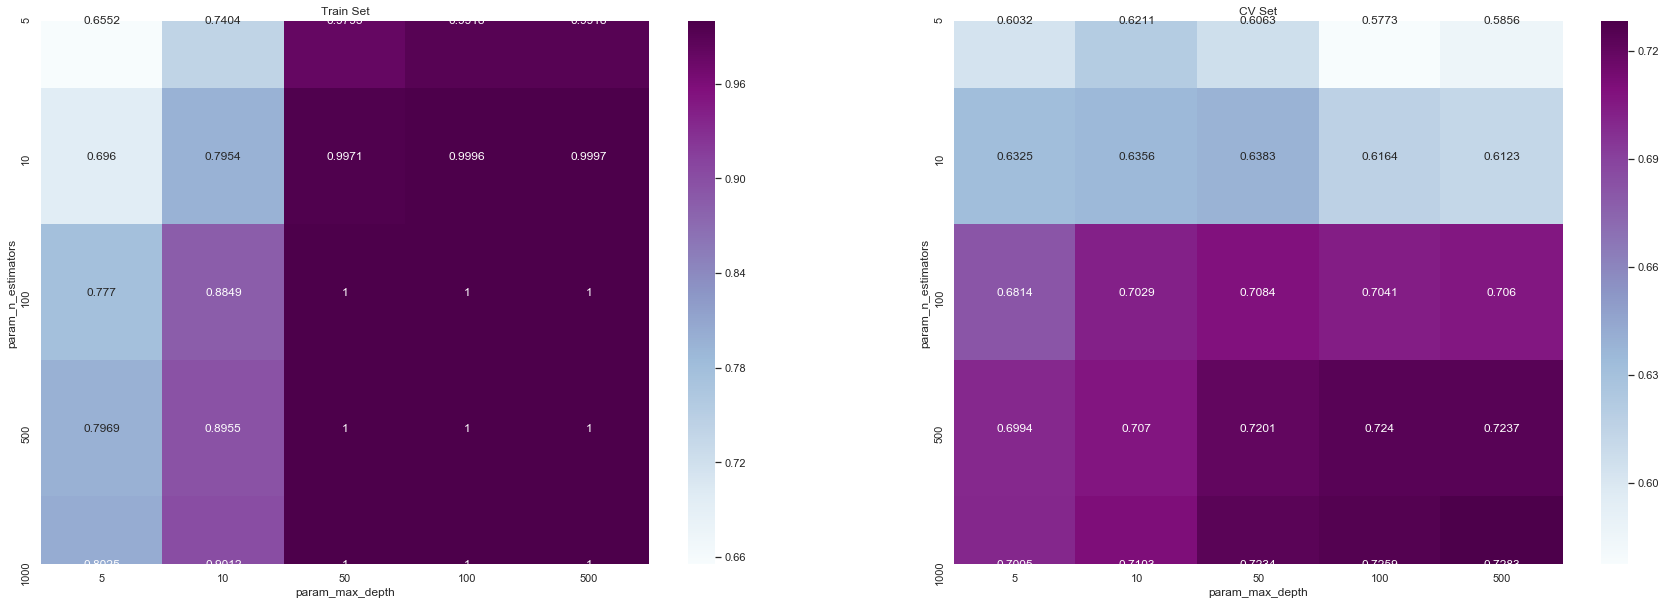

In [311]:
max_scores_bow = RFT.groupby(['param_n_estimators', 
                                    'param_max_depth']).max()
max_scores_bow = max_scores_bow.unstack()[['mean_test_score', 'mean_train_score']]
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9
import seaborn as sns; sns.set()

fig, ax = plt.subplots(1,2, figsize=(30,10))
sns.heatmap(max_scores_bow.mean_train_score, annot = True, fmt='.4g',cmap= "BuPu", ax=ax[0])
sns.heatmap(max_scores_bow.mean_test_score, annot = True, fmt='.4g',cmap="BuPu", ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [ ]:
# best_parameters_bow = [{'max_depth':[10], 'min_samples_split':[500] } ]

# 11.1.2. Testing the performance of the model on test data, plotting ROC Curves

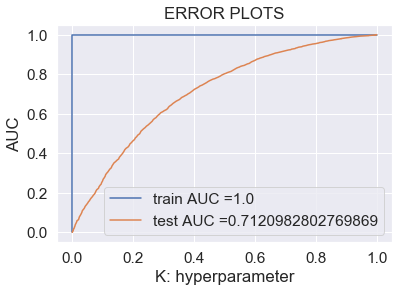

In [312]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


RF = RandomForestClassifier(class_weight = 'balanced', max_depth = 500  ,n_estimators =  1000)
RF.fit(Xtrain1, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_bow = RF.predict_proba(Xtrain1)[:,1]    
y_test_pred_bow = RF.predict_proba(Xtest1)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_bow)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_bow)
sns.set(font_scale = 1.4)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

# 11.1.3. Building Confsuion Matrix

# Function for confusion matrix

In [149]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    global predictions_of_y
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions_of_y = predictions
    return predictions

In [314]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_bow, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_bow, best_t)))

the maximum value of tpr*(1-fpr) 1.0 for threshold 0.766
Train confusion matrix
[[ 3463     0]
 [    0 18982]]
Test confusion matrix
[[ 1006  1540]
 [ 1752 12202]]


In [315]:
confusion_matrix_train_bow = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_bow, best_t)))
confusion_matrix_test_bow = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_bow, best_t)))

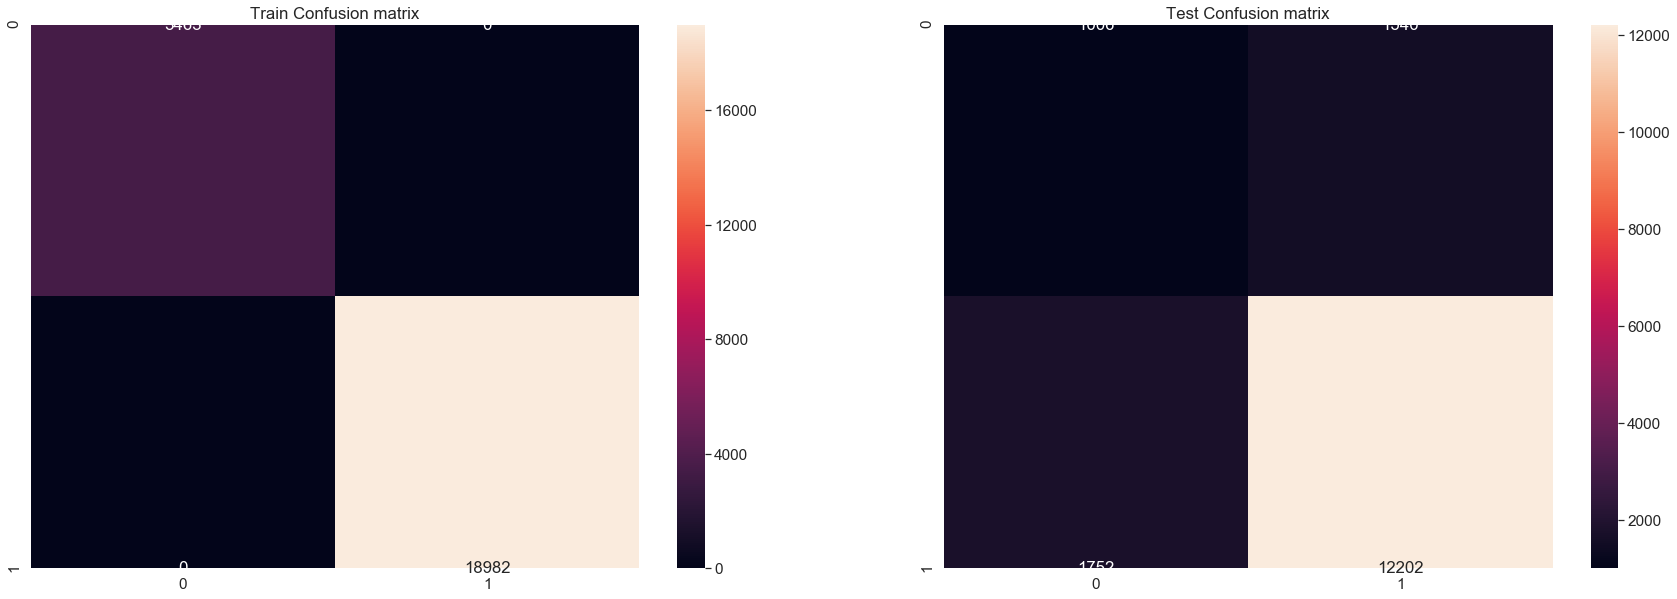

In [316]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 4)
sns.heatmap(confusion_matrix_train_bow,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_bow,annot = True , ax = axes[1],fmt = 'g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 11.2. Applying Random Forests on TFIDF, SET 2

In [317]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sb


RF = RandomForestClassifier(class_weight = 'balanced')
parameters = {'max_depth':(5,10,50,100,500) , 'n_estimators':(5,10,100,500,1000)}
RFT2 = GridSearchCV(RF, parameters, cv=3, scoring='roc_auc',return_train_score=True)
RFT2.fit(Xtrain2, y_train)
print(RFT2.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)


# 11.2.1. Finding The Best Hyperparameter "max_depth" and "n_estimators"

In [318]:
RFT2 = pd.DataFrame.from_dict(RFT2.cv_results_)

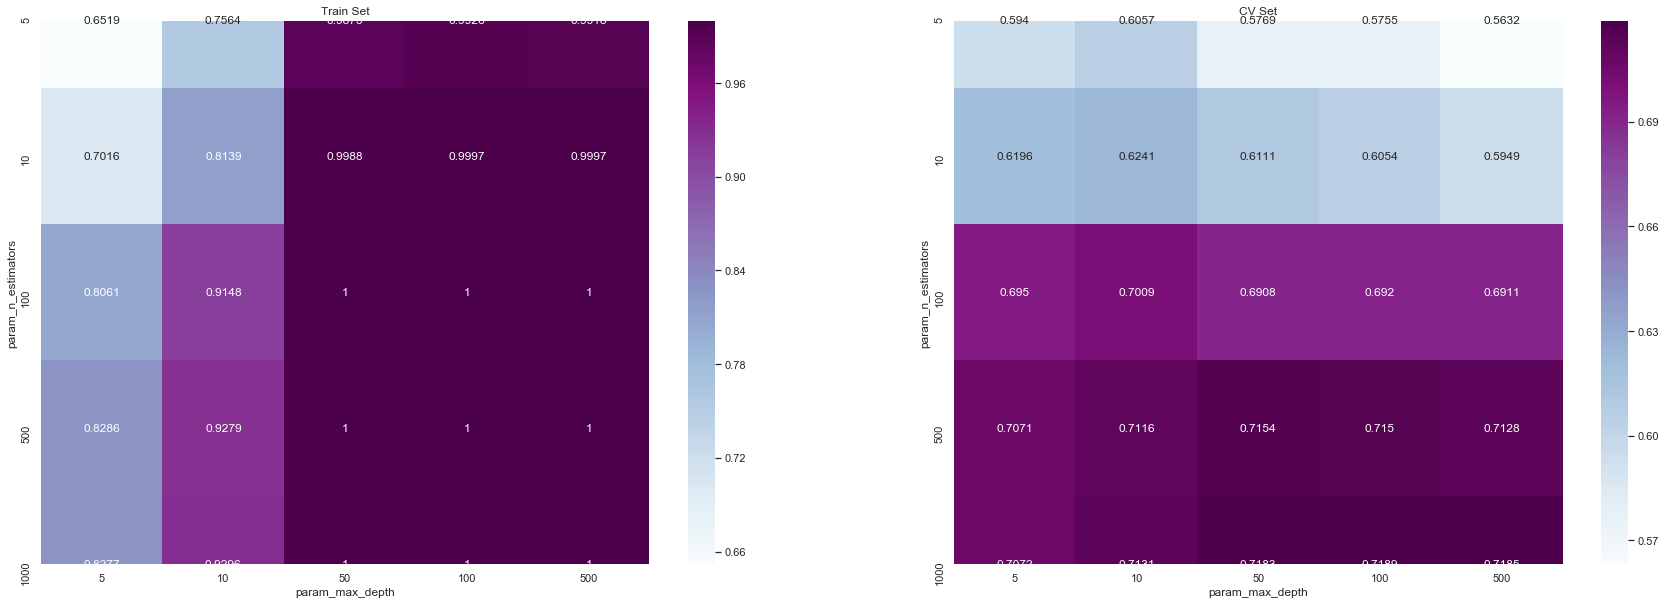

In [319]:
max_scores_tfidf = RFT2.groupby(['param_n_estimators', 
                                    'param_max_depth']).max()
max_scores_tfidf = max_scores_tfidf.unstack()[['mean_test_score', 'mean_train_score']]
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9
import seaborn as sns; sns.set()

fig, ax = plt.subplots(1,2, figsize=(30,10))
sns.heatmap(max_scores_tfidf.mean_train_score, annot = True, fmt='.4g',cmap= "BuPu", ax=ax[0])
sns.heatmap(max_scores_tfidf.mean_test_score, annot = True, fmt='.4g',cmap="BuPu", ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

# 11.2.2. Testing the performance of the model on test data, plotting ROC Curves

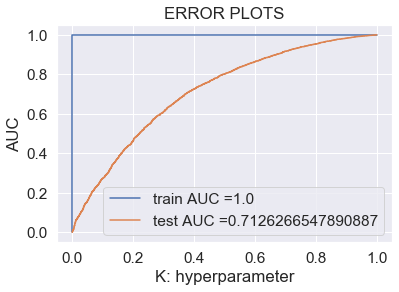

In [320]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


RF2 = RandomForestClassifier(class_weight = 'balanced', max_depth = 100  ,n_estimators =  1000)
RF2.fit(Xtrain2, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_tfidf = RF2.predict_proba(Xtrain2)[:,1]    
y_test_pred_tfidf = RF2.predict_proba(Xtest2)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_tfidf)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_tfidf)
sns.set(font_scale = 1.4)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

# 11.2.3. Buiding Confusion Matrix

In [321]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidf, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidf, best_t)))

the maximum value of tpr*(1-fpr) 1.0 for threshold 0.753
Train confusion matrix
[[ 3463     0]
 [    0 18982]]
Test confusion matrix
[[  844  1702]
 [ 1421 12533]]


In [322]:
confusion_matrix_train_tfidf = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidf, best_t)))
confusion_matrix_test_tfidf = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidf, best_t)))

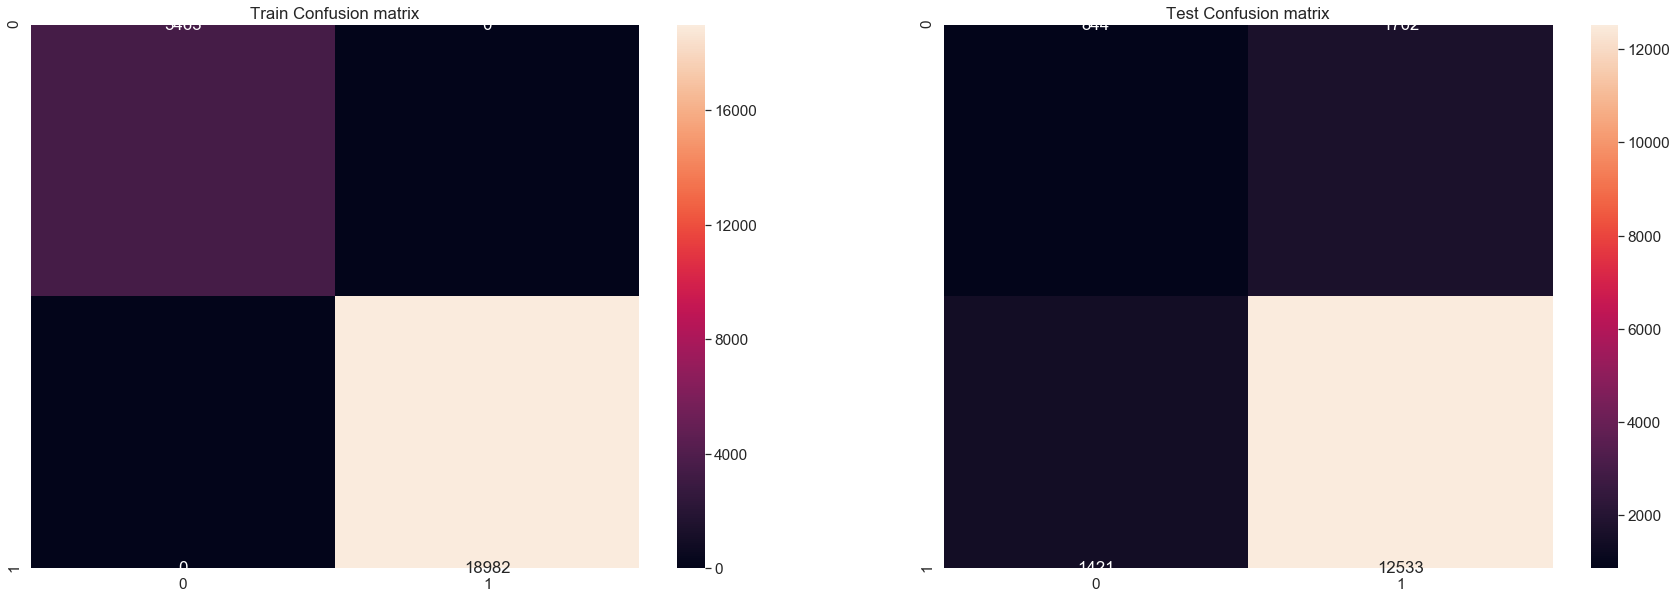

In [323]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 4)
sns.heatmap(confusion_matrix_train_tfidf,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_tfidf,annot = True , ax = axes[1],fmt ='g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 11.3. Applying Random Forests on AVG W2V, SET 3

In [324]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GrisssdSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sb


RF = RandomForestClassifier(class_weight = 'balanced')
parameters = {'max_depth':(5,10,50,100,500) , 'n_estimators':(5,10,100,500,1000)}
RFT3 = GridSearchCV(RF, parameters, cv=3, scoring='roc_auc',return_train_score=True)
RFT3.fit(Xtrain3, y_train)
print(RFT3.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)


# 11.3.1. Finding The Best Hyperparameter "max_depth" and "n_estimators"

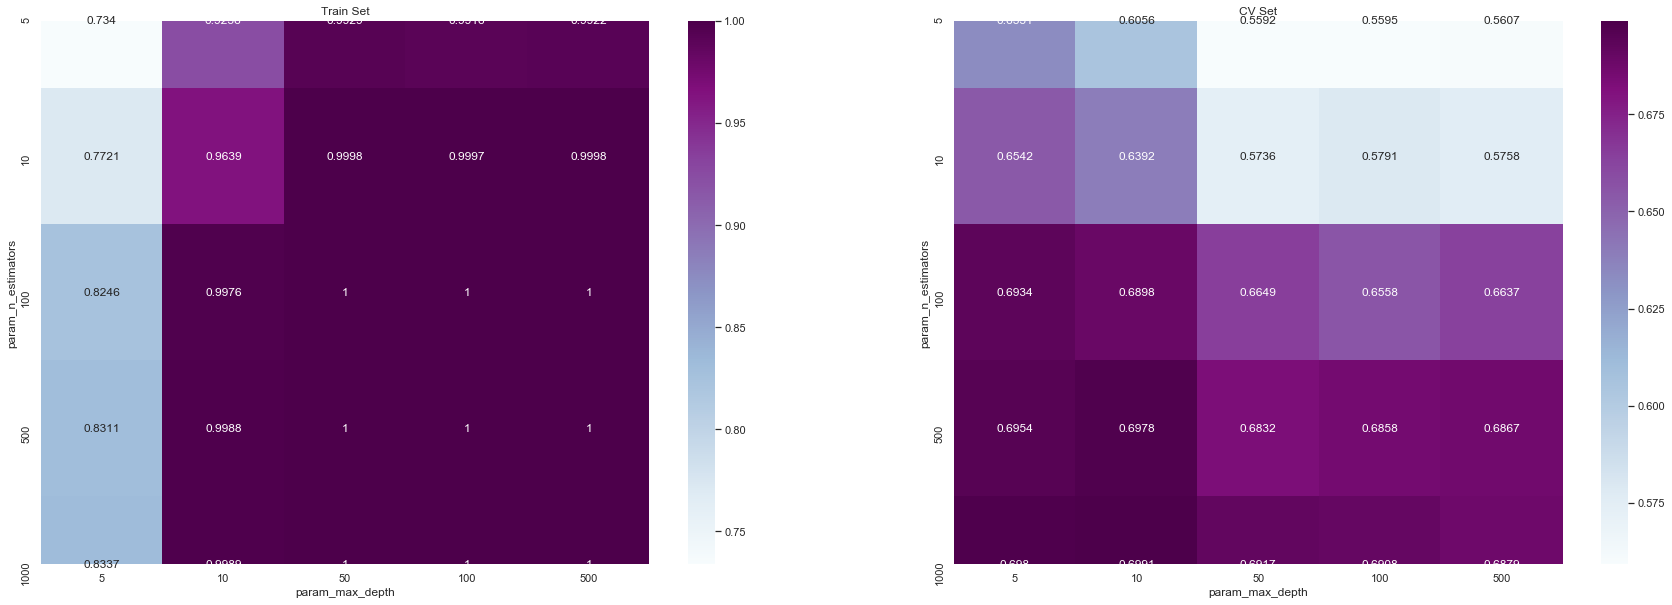

In [325]:
RFT3 = pd.DataFrame(RFT3.cv_results_)
max_scores_avg_w2v = RFT3.groupby(['param_n_estimators', 
                                    'param_max_depth']).max()
max_scores_avg_w2v = max_scores_avg_w2v.unstack()[['mean_test_score', 'mean_train_score']]
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9
import seaborn as sns; sns.set()

fig, ax = plt.subplots(1,2, figsize=(30,10))
sns.heatmap(max_scores_avg_w2v.mean_train_score, annot = True, fmt='.4g',cmap= "BuPu", ax=ax[0])
sns.heatmap(max_scores_avg_w2v.mean_test_score, annot = True, fmt='.4g',cmap="BuPu", ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

# 11.3.2. Testing the performance of the model on test data, plotting ROC Curves

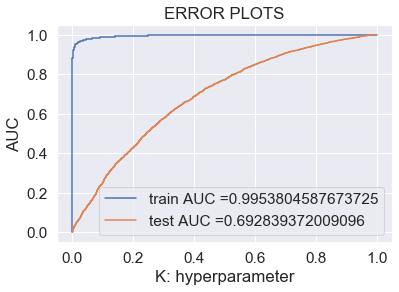

In [326]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


RF3 = RandomForestClassifier(class_weight = 'balanced', max_depth = 10  ,n_estimators =  1000)
RF3.fit(Xtrain3, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_avg_w2v = RF3.predict_proba(Xtrain3)[:,1]    
y_test_pred_avg_w2v = RF3.predict_proba(Xtest3)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_avg_w2v)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_avg_w2v)

sns.set(font_scale = 1.4)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

# 11.3.3. Building Confusion matrix

In [327]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_avg_w2v, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_avg_w2v, best_t)))

the maximum value of tpr*(1-fpr) 0.943469766774201 for threshold 0.534
Train confusion matrix
[[ 3405    58]
 [  768 18214]]
Test confusion matrix
[[  691  1855]
 [ 1139 12815]]


In [328]:
confusion_matrix_train_avg_w2v = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_avg_w2v, best_t)))
confusion_matrix_test_avg_w2v = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_avg_w2v, best_t)))

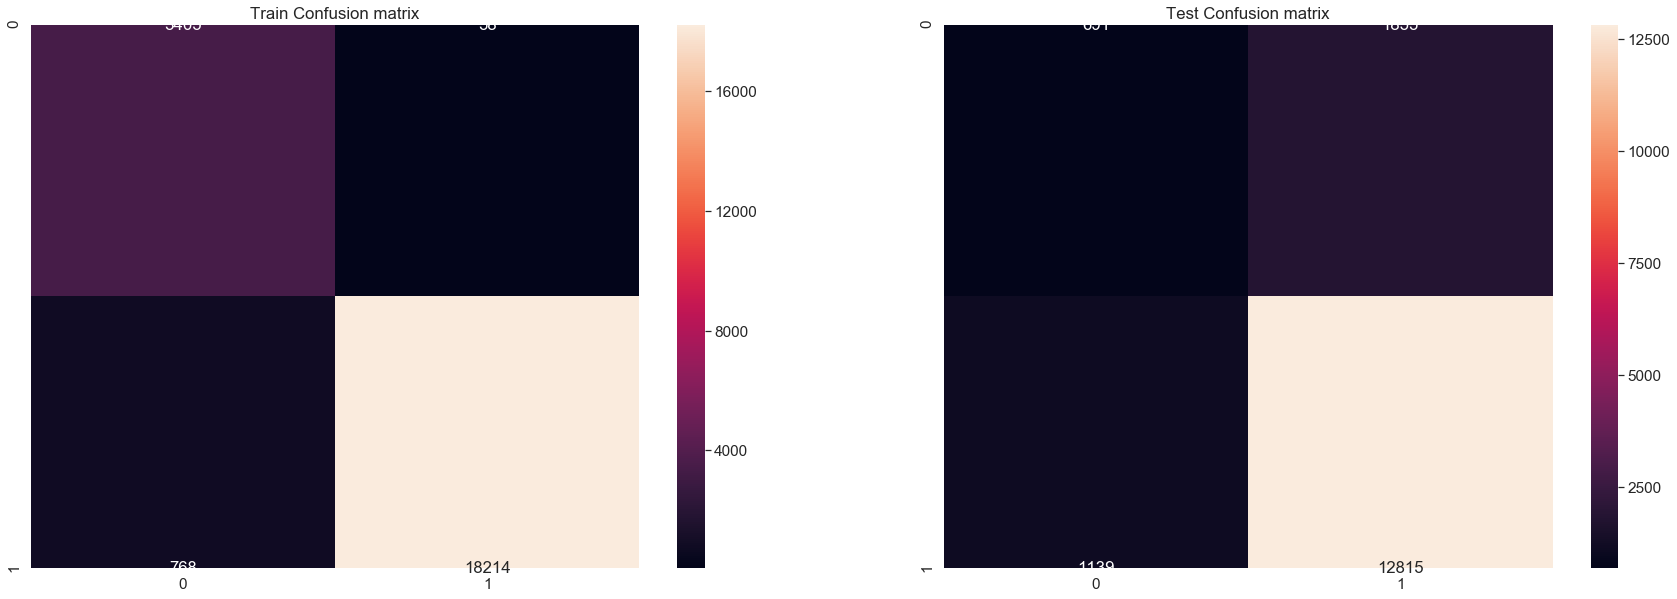

In [329]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 4)
sns.heatmap(confusion_matrix_train_avg_w2v,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_avg_w2v,annot = True , ax = axes[1],fmt = 'g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 11.4. Applying Random Forests on TFIDF W2V, SET 4

In [330]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sb


RF = RandomForestClassifier(class_weight = 'balanced')
parameters = {'max_depth':(5,10,50,100,500) , 'n_estimators':(5,10,100,500,1000)}
RFT4 = GridSearchCV(RF, parameters, cv=3, scoring='roc_auc',return_train_score=True)
RFT4.fit(Xtrain4, y_train)
print(RFT4.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)


# 11.4.1. Finding The Best Hyperparameter "max_depth" and "n_estimators"

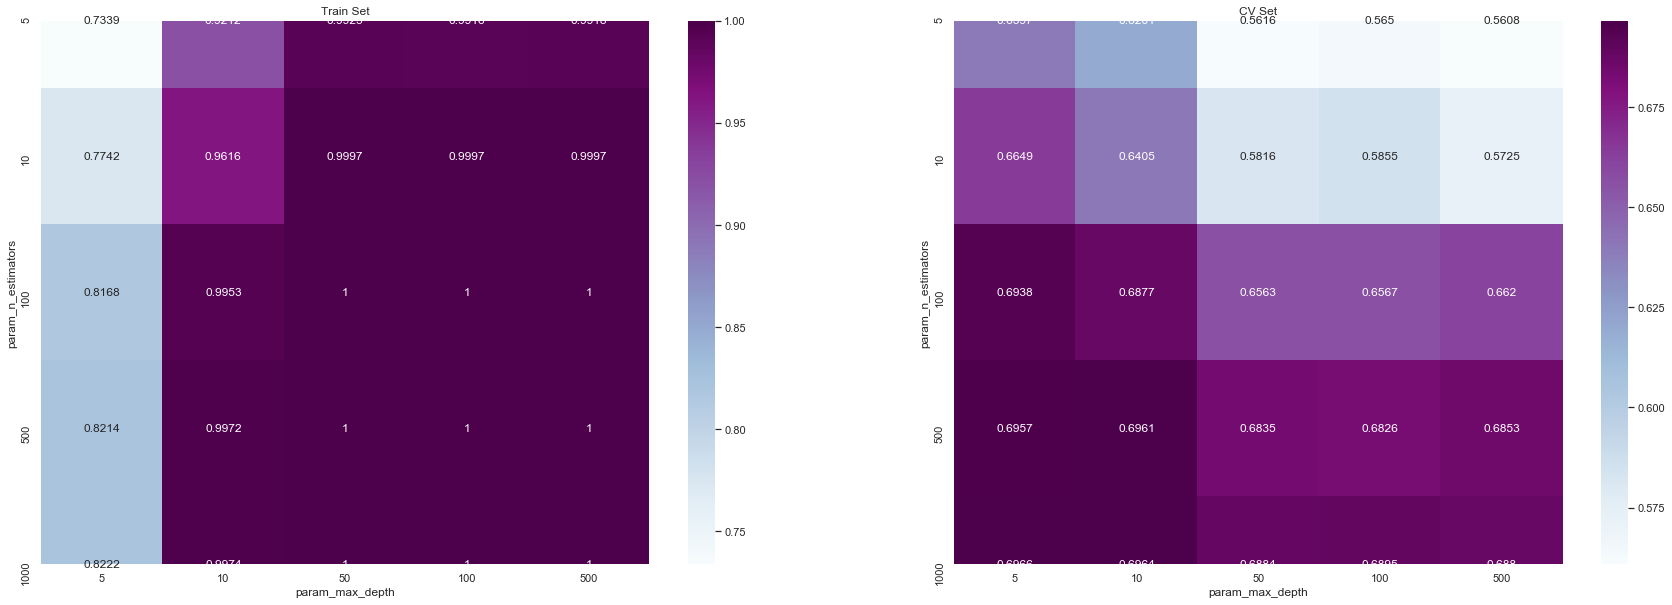

In [331]:
RFT4 = pd.DataFrame.from_dict(RFT4.cv_results_)
max_scores_tfidff_weighted_w2v = RFT4.groupby(['param_n_estimators', 
                                    'param_max_depth']).max()
max_scores_tfidff_weighted_w2v = max_scores_tfidff_weighted_w2v.unstack()[['mean_test_score', 'mean_train_score']]
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9
import seaborn as sns; sns.set()

fig, ax = plt.subplots(1,2, figsize=(30,10))
sns.heatmap(max_scores_tfidff_weighted_w2v.mean_train_score, annot = True, fmt='.4g',cmap= "BuPu", ax=ax[0])
sns.heatmap(max_scores_tfidff_weighted_w2v.mean_test_score, annot = True, fmt='.4g',cmap="BuPu", ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

# 11.4.2. Testing the performance of the model on test data, plotting ROC Curves

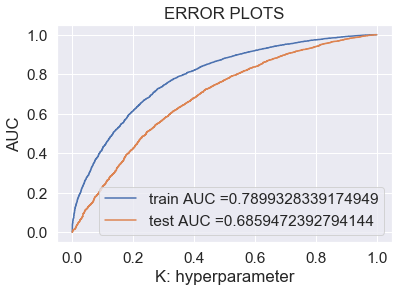

In [334]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


RF4 = RandomForestClassifier(class_weight = 'balanced', max_depth = 5  ,n_estimators =  1000)
RF4.fit(Xtrain4, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_tfidf_weighted_w2v = RF4.predict_proba(Xtrain4)[:,1]    
y_test_pred_tfidf_weighted_w2v = RF4.predict_proba(Xtest4)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_tfidf_weighted_w2v)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_tfidf_weighted_w2v)
sns.set(font_scale = 1.4)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

# 11.4.3. Building Confusion Matrix

In [335]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidf_weighted_w2v, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidf_weighted_w2v, best_t)))

the maximum value of tpr*(1-fpr) 0.5227757603575562 for threshold 0.498
Train confusion matrix
[[ 2490   973]
 [ 5181 13801]]
Test confusion matrix
[[1452 1094]
 [4033 9921]]


In [336]:
confusion_matrix_train_tfidf_weighted_w2v = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidf_weighted_w2v, best_t)))
confusion_matrix_test_tfidf_weighted_w2v = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidf_weighted_w2v, best_t)))

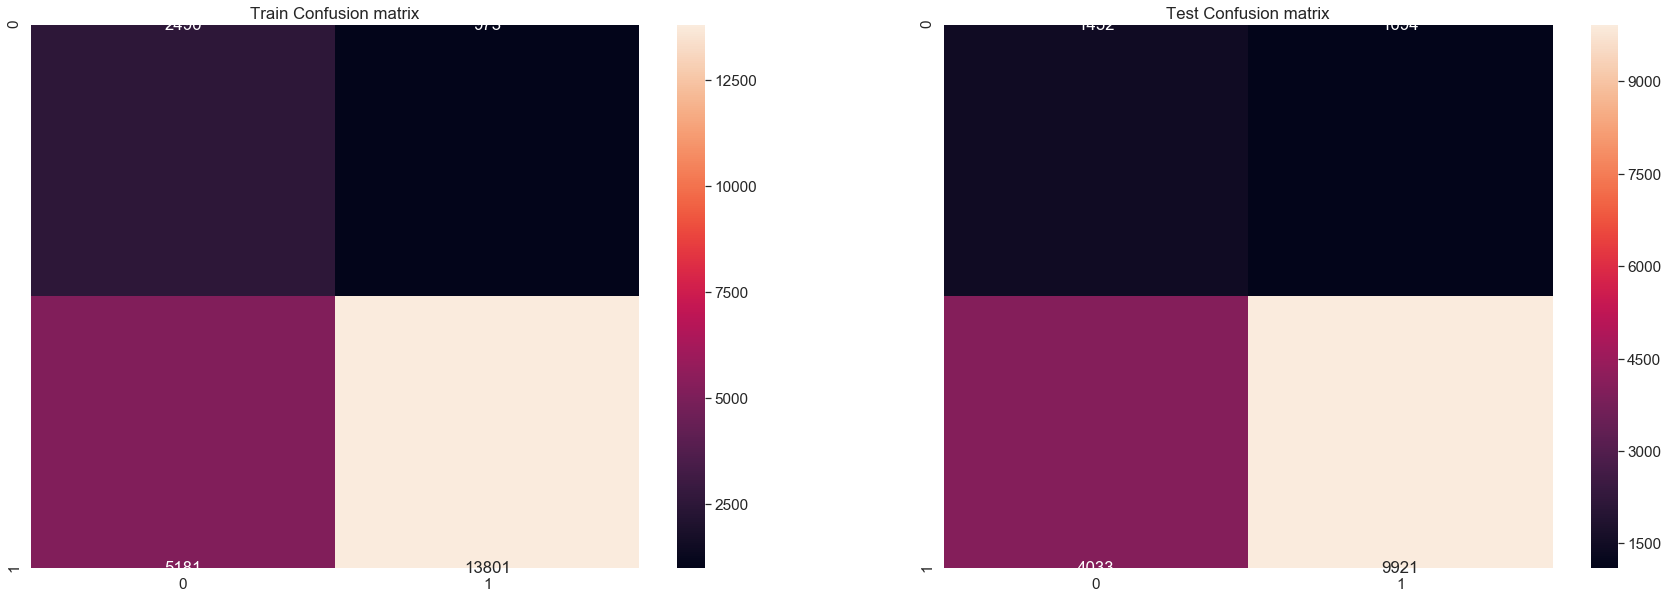

In [337]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 4)
sns.heatmap(confusion_matrix_train_tfidf_weighted_w2v,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_tfidf_weighted_w2v,annot = True , ax = axes[1],fmt ='g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 12. Applying GBDT on different kind of featurization

# 12.1. Applying XGBOOST on BOW, SET 1

In [342]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost
import seaborn as sb


XG = xgboost.XGBClassifier(scale_pos_weight=1, n_jobs = -1)
parameters = {'max_depth':(5,10,50,100,500) , 'n_estimators':(5,10,100,500,1000)}
XGB = GridSearchCV(XG, parameters, cv=3, scoring='roc_auc',return_train_score=True)
XGB.fit(Xtrain1, y_train)
print('Best estimator', XGB.best_estimator_)
print('Best score', XGB.best_score_)

Best estimator XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Best score 0.7267182263981559


# 12.1.1. Finding The Best Hyperparameter "max_depth" and "n_estimators"

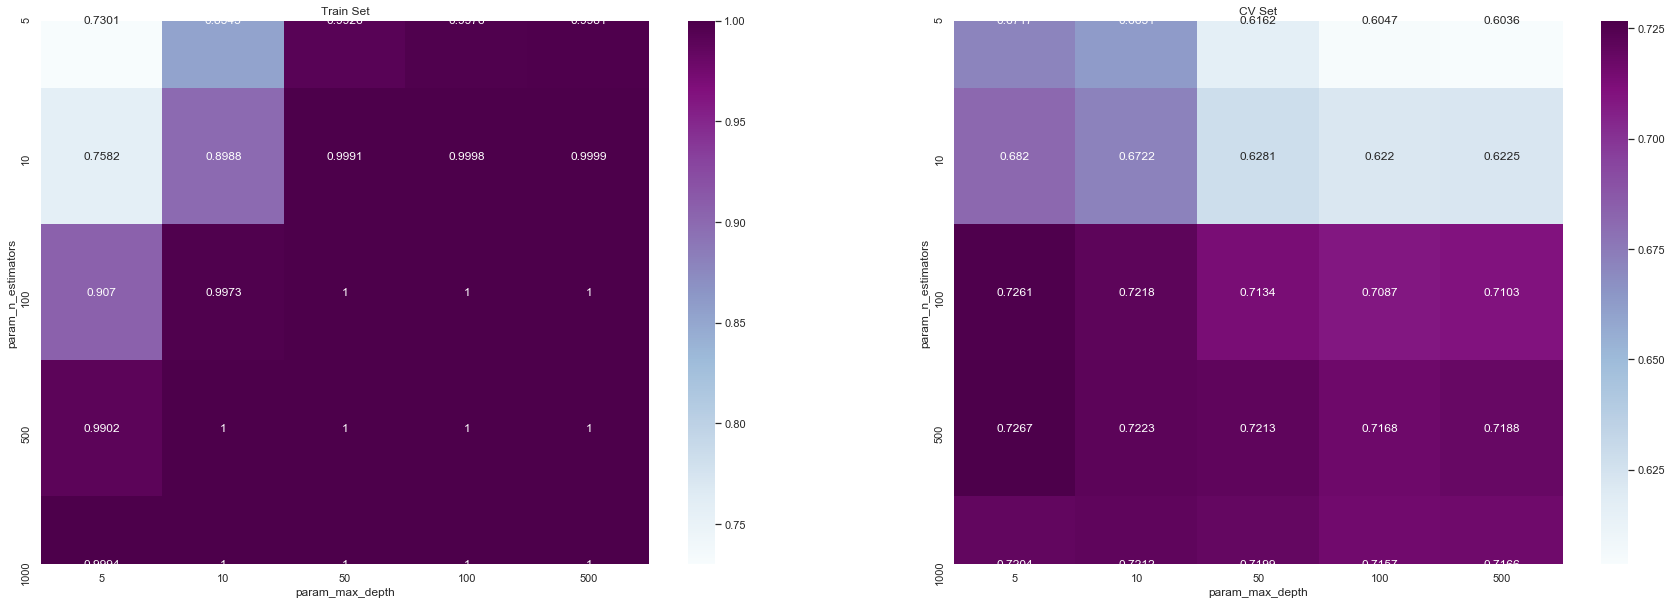

In [343]:
XGB = pd.DataFrame.from_dict(XGB.cv_results_)
max_scores_bow = XGB.groupby(['param_n_estimators', 
                                    'param_max_depth']).max()
max_scores_bow = max_scores_bow.unstack()[['mean_test_score', 'mean_train_score']]
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9
import seaborn as sns; sns.set()

fig, ax = plt.subplots(1,2, figsize=(30,10))
sns.heatmap(max_scores_bow.mean_train_score, annot = True, fmt='.4g',cmap= "BuPu", ax=ax[0])
sns.heatmap(max_scores_bow.mean_test_score, annot = True, fmt='.4g',cmap="BuPu", ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

# 12.1.2. Testing the performance of the model on test data, plotting ROC Curves

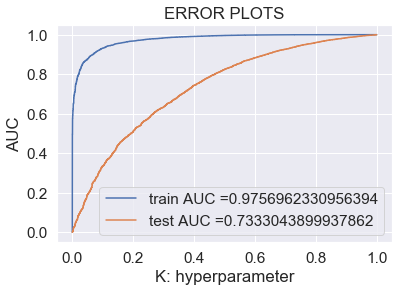

In [345]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


XG1 = xgboost.XGBClassifier(scale_pos_weight=1,n_jobs = -1, max_depth = 5  ,n_estimators =  500)
XG1.fit(Xtrain1, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_bow = XG1.predict_proba(Xtrain1)[:,1]    
y_test_pred_bow = XG1.predict_proba(Xtest1)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_bow)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_bow)
sns.set(font_scale = 1.4)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

# 12.1.3. Building Confusion matrix

In [346]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_bow, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_bow, best_t)))

the maximum value of tpr*(1-fpr) 0.8421134747988221 for threshold 0.776
Train confusion matrix
[[ 3177   286]
 [ 1558 17424]]
Test confusion matrix
[[ 1153  1393]
 [ 2045 11909]]


In [347]:
confusion_matrix_train_bow = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_bow, best_t)))
confusion_matrix_test_bow = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_bow, best_t)))

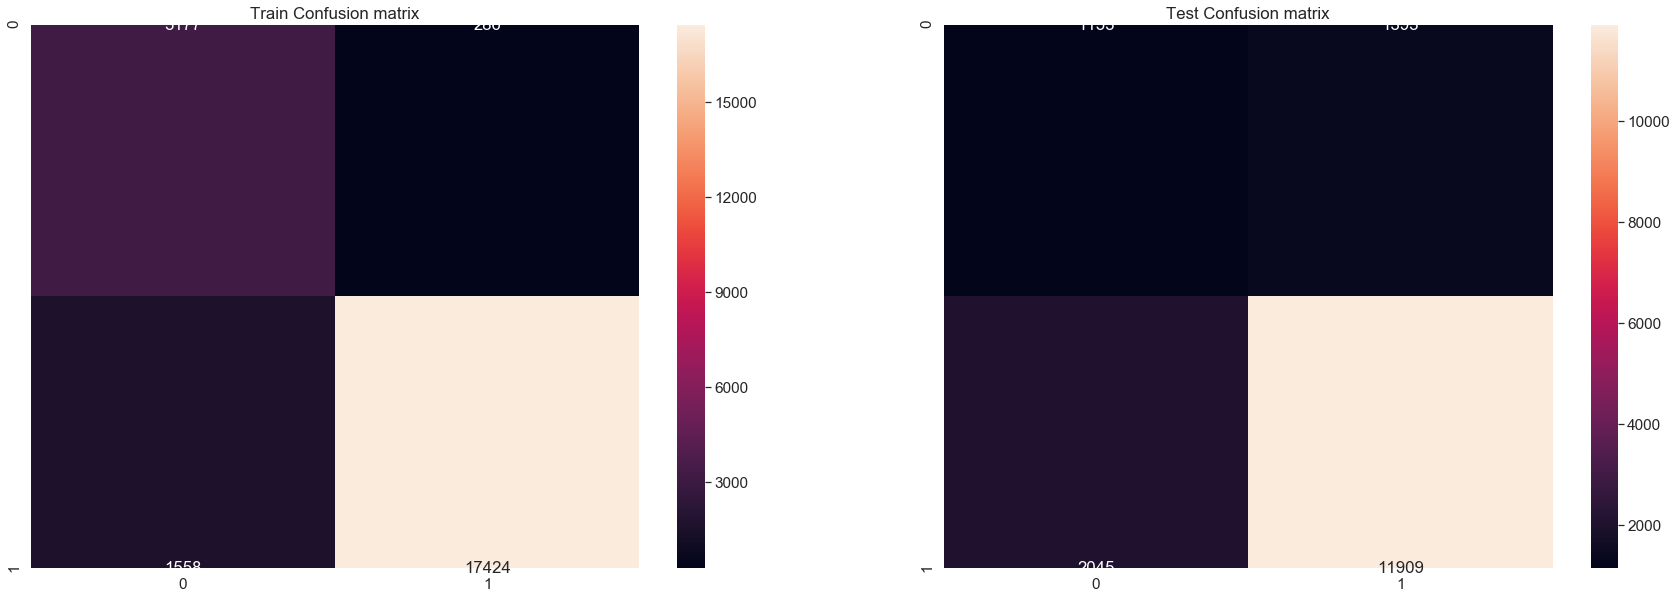

In [348]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 4)
sns.heatmap(confusion_matrix_train_bow,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_bow,annot = True , ax = axes[1],fmt = 'g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 12.2. Applying XGBOOST on TFIDF, SET 2

In [349]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost
import seaborn as sb


XG = xgboost.XGBClassifier(scale_pos_weight=1, n_jobs = -1)
parameters = {'max_depth':(5,10,50,100,500) , 'n_estimators':(5,10,100,500,1000)}
XGB2 = GridSearchCV(XG, parameters, cv=3, scoring='roc_auc',return_train_score=True)
XGB2.fit(Xtrain2, y_train)
print('Best estimator', XGB2.best_estimator_)
print('Best score', XGB2.best_score_)

Best estimator XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Best score 0.7255455767717093


# 12.2.1. Finding The Best Hyperparameter "max_depth" and "n_estimators"

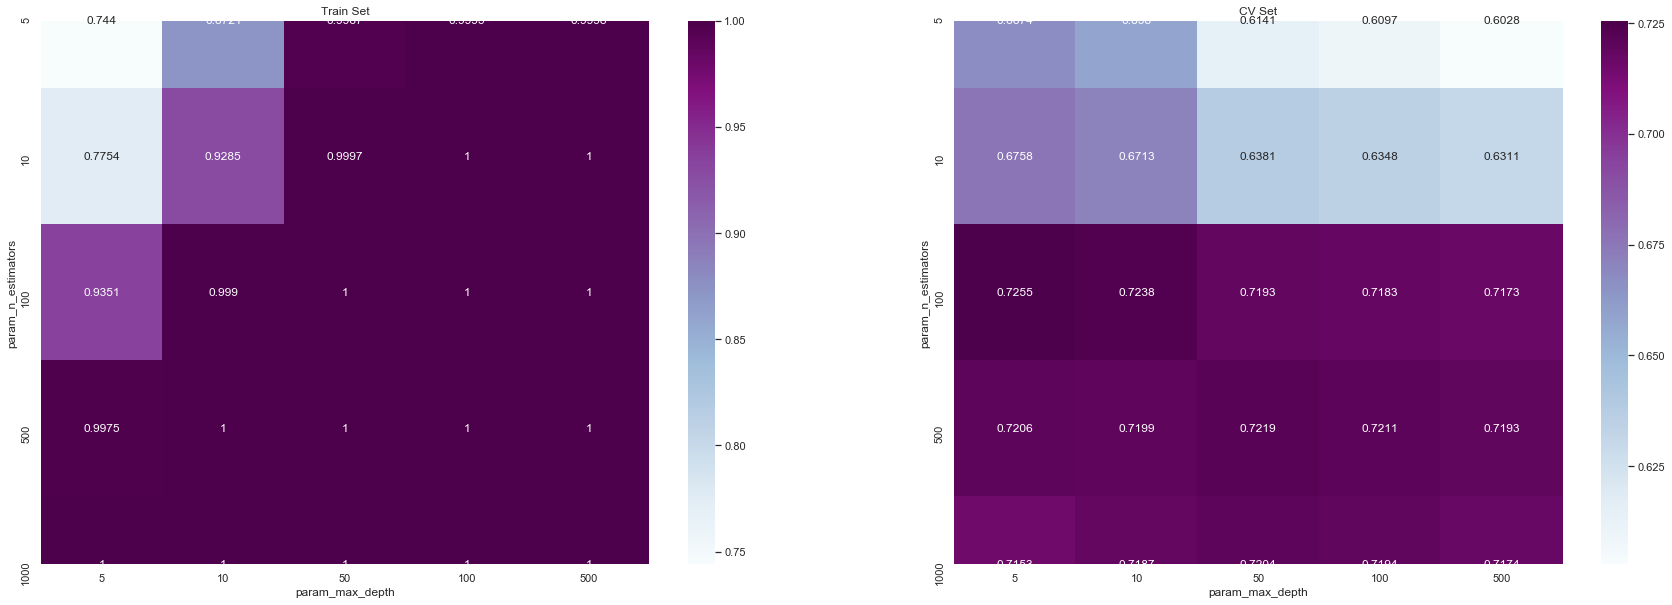

In [350]:
XGB2 = pd.DataFrame.from_dict(XGB2.cv_results_)
max_scores_tfidf = XGB2.groupby(['param_n_estimators', 
                                    'param_max_depth']).max()
max_scores_tfidf = max_scores_tfidf.unstack()[['mean_test_score', 'mean_train_score']]
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9
import seaborn as sns; sns.set()

fig, ax = plt.subplots(1,2, figsize=(30,10))
sns.heatmap(max_scores_tfidf.mean_train_score, annot = True, fmt='.4g',cmap= "BuPu", ax=ax[0])
sns.heatmap(max_scores_tfidf.mean_test_score, annot = True, fmt='.4g',cmap="BuPu", ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

# 12.2.2. Testing the performance of the model on test data, plotting ROC Curves

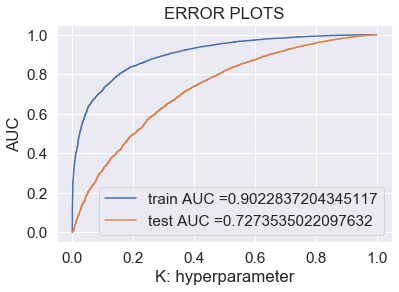

In [351]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


XG2 = xgboost.XGBClassifier(scale_pos_weight=1,n_jobs = -1, max_depth = 5  ,n_estimators =  100)
XG2.fit(Xtrain2, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_tfidf = XG2.predict_proba(Xtrain2)[:,1]    
y_test_pred_tfidf = XG2.predict_proba(Xtest2)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_tfidf)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_tfidf)
sns.set(font_scale = 1.4)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

# 12.2.3. Building Confusion matrix

In [352]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidf, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidf, best_t)))

the maximum value of tpr*(1-fpr) 0.6775435962510253 for threshold 0.825
Train confusion matrix
[[ 2919   544]
 [ 3724 15258]]
Test confusion matrix
[[ 1464  1082]
 [ 3372 10582]]


In [353]:
confusion_matrix_train_tfidf = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidf, best_t)))
confusion_matrix_test_tfidf = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidf, best_t)))

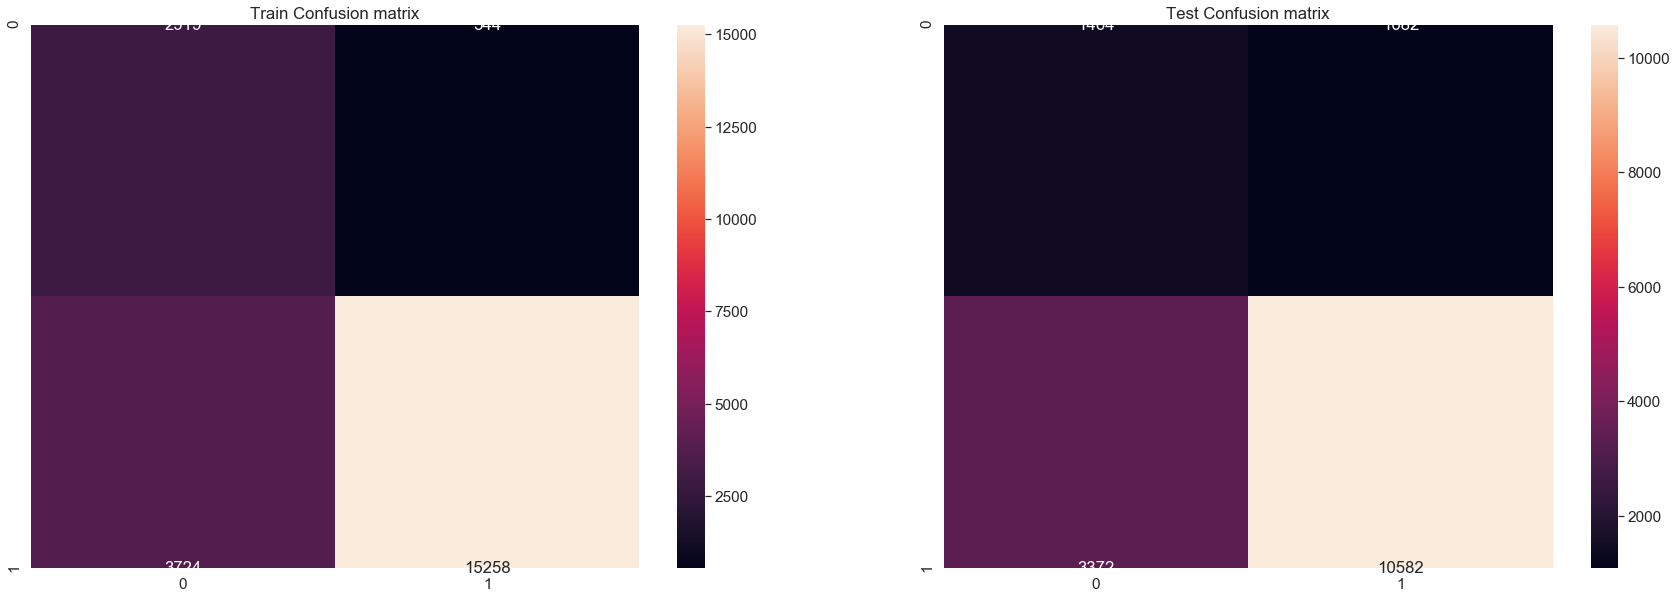

In [354]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 4)
sns.heatmap(confusion_matrix_train_tfidf,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_tfidf,annot = True , ax = axes[1],fmt ='g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 12.3. Applying Random Forests on AVG W2V, SET 3

In [355]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost
import seaborn as sb


XG = xgboost.XGBClassifier(scale_pos_weight=1, n_jobs = -1)
parameters = {'max_depth':(5,10,50,100,500) , 'n_estimators':(5,10,100,500,1000)}
XGB3 = GridSearchCV(XG, parameters, cv=3, scoring='roc_auc',return_train_score=True)
XGB3.fit(Xtrain3, y_train)
print('Best estimator', XGB3.best_estimator_)
print('Best score', XGB3.best_score_)

Best estimator XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Best score 0.7197987856804764


# 12.3.1. Finding The Best Hyperparameter "max_depth" and "n_estimators"

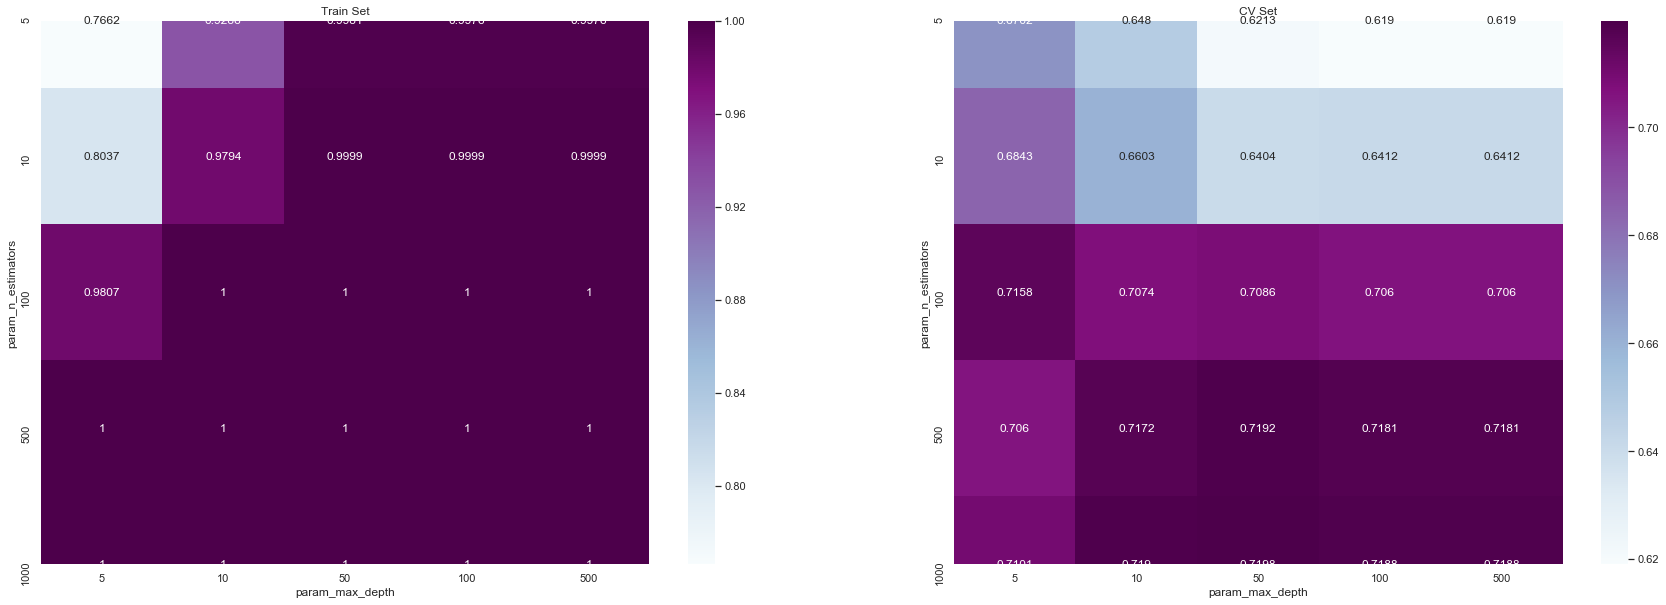

In [356]:
XGB3 = pd.DataFrame(XGB3.cv_results_)
max_scores_avg_w2v = XGB3.groupby(['param_n_estimators', 
                                    'param_max_depth']).max()
max_scores_avg_w2v = max_scores_avg_w2v.unstack()[['mean_test_score', 'mean_train_score']]
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9
import seaborn as sns; sns.set()

fig, ax = plt.subplots(1,2, figsize=(30,10))
sns.heatmap(max_scores_avg_w2v.mean_train_score, annot = True, fmt='.4g',cmap= "BuPu", ax=ax[0])
sns.heatmap(max_scores_avg_w2v.mean_test_score, annot = True, fmt='.4g',cmap="BuPu", ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

# 12.3.2. Testing the performance of the model on test data, plotting ROC Curves

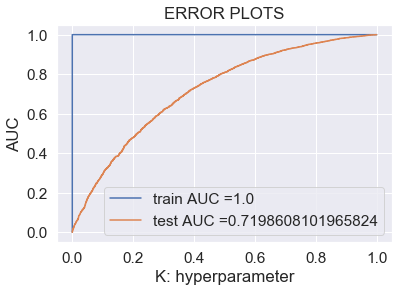

In [357]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


XG3 = xgboost.XGBClassifier(scale_pos_weight=1,n_jobs = -1, max_depth = 50  ,n_estimators =  1000)
XG3.fit(Xtrain3, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_avg_w2v = XG3.predict_proba(Xtrain3)[:,1]    
y_test_pred_avg_w2v = XG3.predict_proba(Xtest3)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_avg_w2v)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_avg_w2v)

sns.set(font_scale = 1.4)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

# 12.3.3. Building Confusion matrix

In [358]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_avg_w2v, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_avg_w2v, best_t)))

the maximum value of tpr*(1-fpr) 1.0 for threshold 0.995
Train confusion matrix
[[ 3463     0]
 [    0 18982]]
Test confusion matrix
[[1654  892]
 [4531 9423]]


In [359]:
confusion_matrix_train_avg_w2v = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_avg_w2v, best_t)))
confusion_matrix_test_avg_w2v = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_avg_w2v, best_t)))

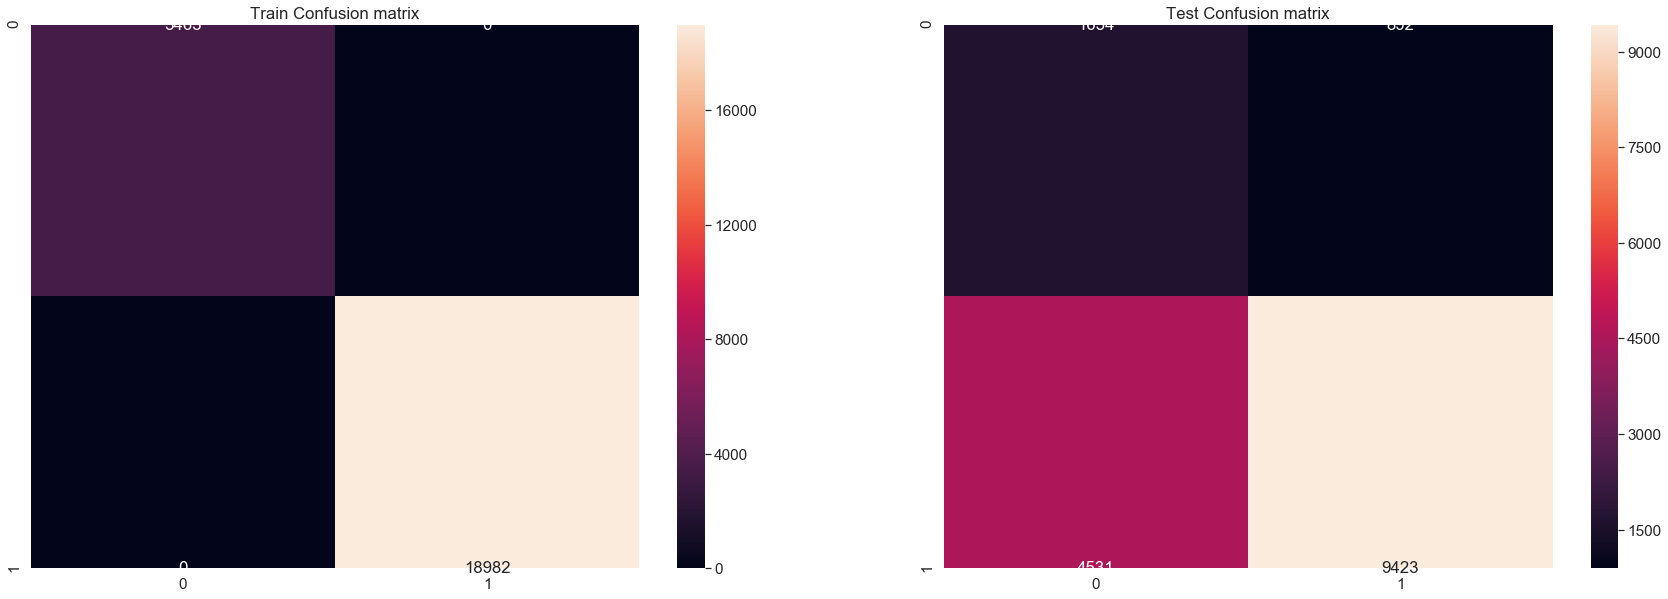

In [360]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 4)
sns.heatmap(confusion_matrix_train_avg_w2v,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_avg_w2v,annot = True , ax = axes[1],fmt = 'g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 12.4. Applying Random Forests on TFIDF W2V, SET 4

In [144]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost
import seaborn as sb


XG = xgboost.XGBClassifier(scale_pos_weight=1, n_jobs = -1)
parameters = {'max_depth':(5,10,50,100,500) , 'n_estimators':(5,10,100,500,1000)}
XGB4 = GridSearchCV(XG, parameters, cv=3, scoring='roc_auc',return_train_score=True)
XGB4.fit(Xtrain4, y_train)
print('Best estimator', XGB4.best_estimator_)
print('Best score', XGB4.best_score_)

Best estimator XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
Best score 0.7183001870051354


# 12.4.1. Finding The Best Hyperparameter "max_depth" and "n_estimators"

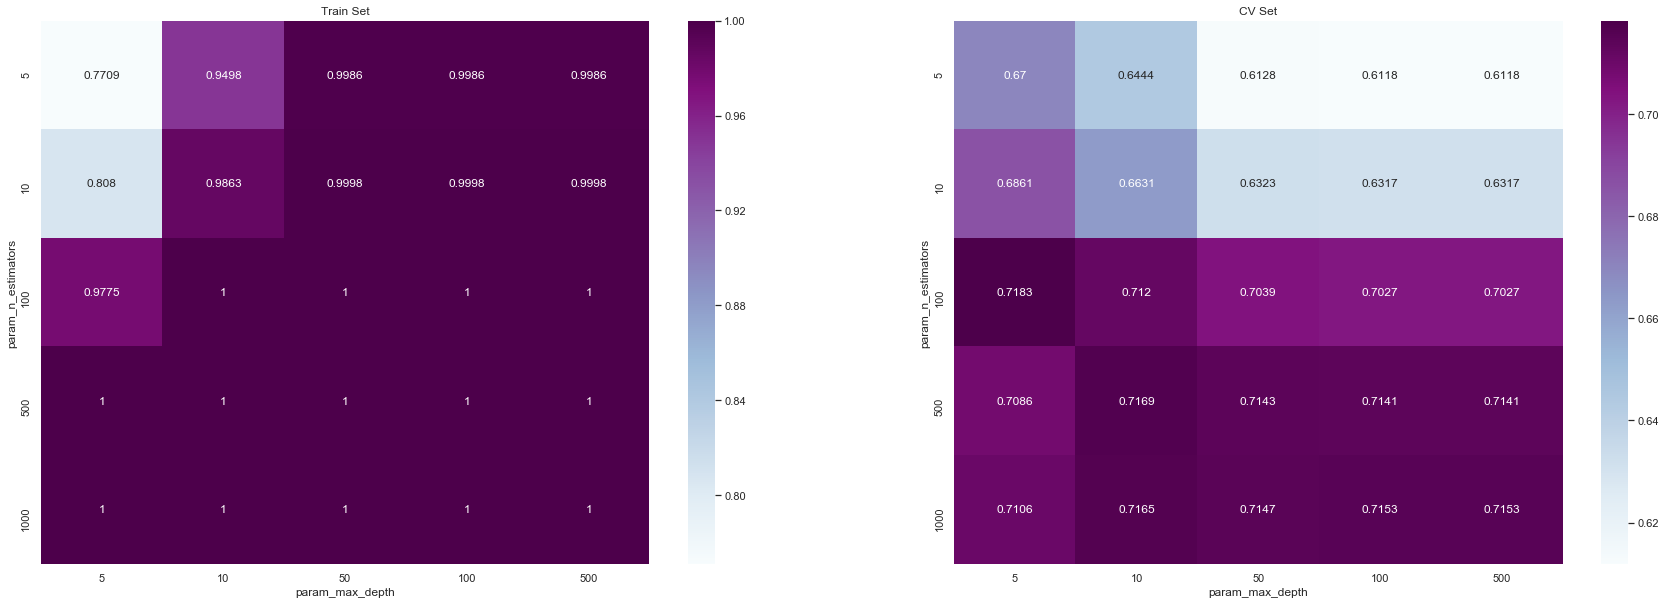

In [145]:
XGB4 = pd.DataFrame.from_dict(XGB4.cv_results_)
max_scores_tfidff_weighted_w2v = XGB4.groupby(['param_n_estimators', 
                                    'param_max_depth']).max()
max_scores_tfidff_weighted_w2v = max_scores_tfidff_weighted_w2v.unstack()[['mean_test_score', 'mean_train_score']]
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9
import seaborn as sns; sns.set()

fig, ax = plt.subplots(1,2, figsize=(30,10))
sns.heatmap(max_scores_tfidff_weighted_w2v.mean_train_score, annot = True, fmt='.4g',cmap= "BuPu", ax=ax[0])
sns.heatmap(max_scores_tfidff_weighted_w2v.mean_test_score, annot = True, fmt='.4g',cmap="BuPu", ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

# 12.4.2. Testing the performance of the model on test data, plotting ROC Curves

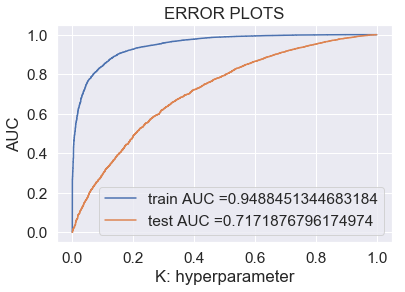

In [146]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


XG4 = xgboost.XGBClassifier(scale_pos_weight=1,n_jobs = -1, max_depth = 5  ,n_estimators =  100)
XG4.fit(Xtrain4, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_tfidf_weighted_w2v = XG4.predict_proba(Xtrain4)[:,1]    
y_test_pred_tfidf_weighted_w2v = XG4.predict_proba(Xtest4)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_tfidf_weighted_w2v)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_tfidf_weighted_w2v)
sns.set(font_scale = 1.4)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()


# 12.4.3. Building Confusion matrix

In [150]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidf_weighted_w2v, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidf_weighted_w2v, best_t)))

the maximum value of tpr*(1-fpr) 0.768356836254405 for threshold 0.792
Train confusion matrix
[[ 2995   468]
 [ 2118 16864]]
Test confusion matrix
[[ 1212  1334]
 [ 2589 11365]]


In [151]:
confusion_matrix_train_tfidf_weighted_w2v = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidf_weighted_w2v, best_t)))
confusion_matrix_test_tfidf_weighted_w2v = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidf_weighted_w2v, best_t)))

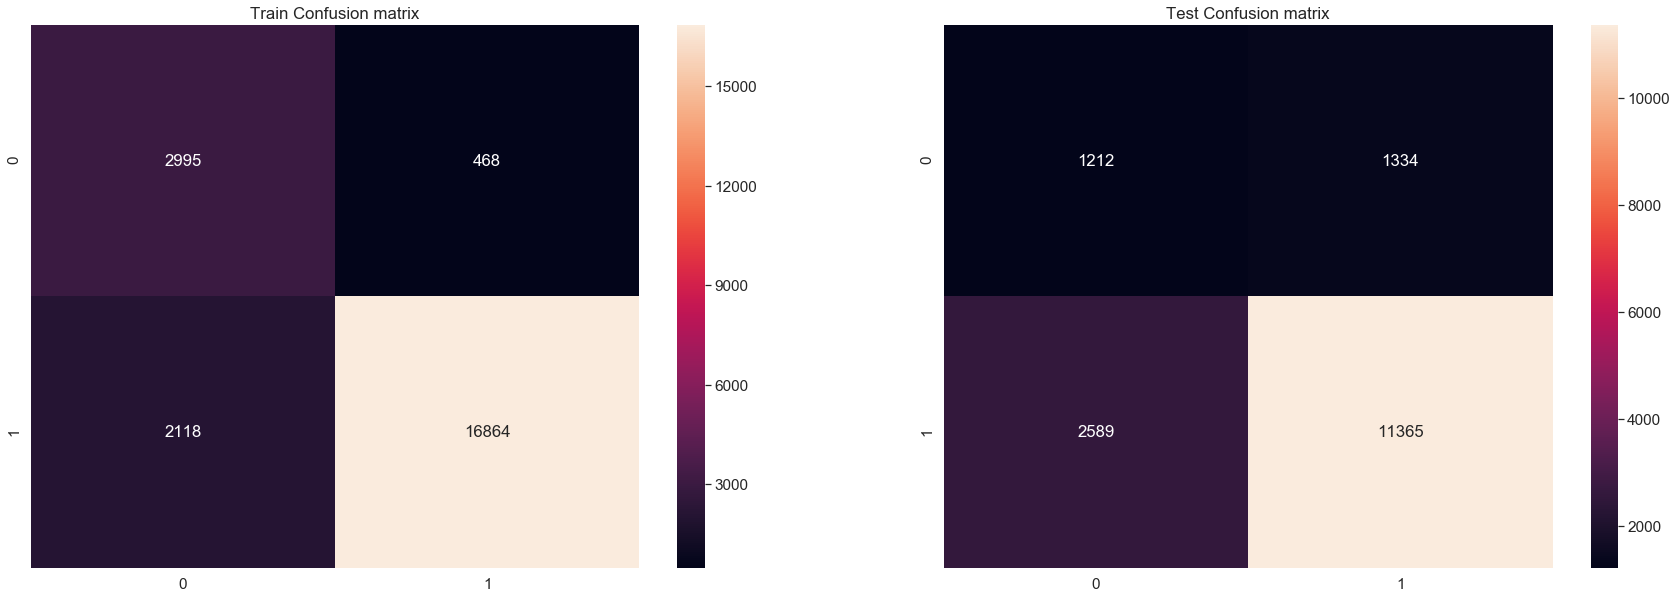

In [152]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 4)
sns.heatmap(confusion_matrix_train_tfidf_weighted_w2v,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_tfidf_weighted_w2v,annot = True , ax = axes[1],fmt ='g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 13. Conclusion

In [10]:

# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "max_depth","n_estimators" ,"Train AUC","Test AUC"]

x.add_row(["BOW", "Random Forest", 500,1000,1, 0.7120])
x.add_row(["TFIDF", "Random Forest", 100,1000,1, 0.7126])
x.add_row(["W2V", "Random Forest", 10,1000,0.9953, 0.6928])
x.add_row(["TFIDF W2V","Random Forest", 5,1000,0.7899, 0.6859])


print ("RANDOM FOREST \n")
print(x)
# http://zetcode.com
           
           
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

y = PrettyTable()

y.field_names = ["Vectorizer", "Model", "max_depth","n_estimators" ,"Train AUC","Test AUC"]

y.add_row(["BOW", "XG Boost", 5,500,0.9756, 0.7333])
y.add_row(["TFIDF", "XG Boost", 5,100,0.9022, 0.7273])
y.add_row(["W2V", "XG Boost", 50,1000,1, 0.7198])
y.add_row(["TFIDF W2V","XG Boost", 5,100,0.9488, 0.7171])

print("\n")
print("XG BOOST \n")
print(y)

RANDOM FOREST 

+------------+---------------+-----------+--------------+-----------+----------+
| Vectorizer |     Model     | max_depth | n_estimators | Train AUC | Test AUC |
+------------+---------------+-----------+--------------+-----------+----------+
|    BOW     | Random Forest |    500    |     1000     |     1     |  0.712   |
|   TFIDF    | Random Forest |    100    |     1000     |     1     |  0.7126  |
|    W2V     | Random Forest |     10    |     1000     |   0.9953  |  0.6928  |
| TFIDF W2V  | Random Forest |     5     |     1000     |   0.7899  |  0.6859  |
+------------+---------------+-----------+--------------+-----------+----------+


XG BOOST 

+------------+----------+-----------+--------------+-----------+----------+
| Vectorizer |  Model   | max_depth | n_estimators | Train AUC | Test AUC |
+------------+----------+-----------+--------------+-----------+----------+
|    BOW     | XG Boost |     5     |     500      |   0.9756  |  0.7333  |
|   TFIDF    | XG B